# Chapter 6 - Using gate-based Quantum Computers - Some basic quantum algorithms 
3. Circuit inspired by the Google Supremacy Experiment

© 2021, 2022 Packt Publishing

Written by Alex Khan

In [1]:
# Enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-[your bucket]" # the name of the bucket
my_prefix = "[your folder]" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [2]:
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np

In [4]:
def available_devices():
    from braket.aws import AwsDevice
    device_list=AwsDevice.get_devices(statuses=['ONLINE'])
    device_name_list=[]
    for device in device_list:
        device_name_list.append(device.name)
    #print('Valid device names: ',device_name_list)
    return(device_name_list)

In [5]:
def set_device(Name):
    device_list=AwsDevice.get_devices(names=Name)
    if len(device_list)==1:
        device=device_list[0]
        print(device)
        return(device)
    else:
        print('No device found')
        print('use name from list', available_devices())

In [6]:
def estimate_cost(device,num_shots=1000):
    #device=set_device(Name)
    cost_per_task=0.30
    Name=device.name
    if Name in ['SV1','TN1','dm1']:
        price_per_min=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('simulator cost per ',unit,': $', price_per_min)
        print('total cost cannot be estimated')
    elif Name in['Advantage_system1.1','DW_2000Q_6','Aspen-9','IonQ Device']:
        price_per_shot=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('device cost per ',unit,': $', price_per_shot)
        print('total cost for {} shots is ${:.2f}'.format(num_shots,cost_per_task+num_shots*price_per_shot))
    else:
        print('device not found')
        print('use name from list', available_devices())


In [7]:
# This function was modified with a return of num_shots
def estimate_cost_measured_qubits(device,measured_qubits):
    #device=set_device(Name)
    min_shots_per_variable=25
    max_shots=device.properties.service.shotsRange[1]
    print('max shots:', max_shots)
    num_shots=min_shots_per_variable*2**measured_qubits
    if num_shots>max_shots:
        num_shots=max_shots
        print('for {} measured qubits the maximum allowed shots: {:,}'.format(measured_qubits,num_shots))
    else:
        print('for {} measured qubits the number of shots recommended: {:,}'.format(measured_qubits,num_shots))
    estimate_cost(device,num_shots)
    return(num_shots)

In [8]:
def actual_simulator_cost(device, result):
        price_per_min=device.properties.service.deviceCost.price
        price_per_ms=price_per_min/60/1000
        unit=device.properties.service.deviceCost.unit
        duration_ms=result.additional_metadata.simulatorMetadata.executionDuration
        if unit=='minute':
            print('simulator cost per ',unit,': $', price_per_min)
            print('total execution time: ', duration_ms, "ms")
            print('total cost estimated: $',duration_ms*price_per_ms)

In [9]:
# this function has been updated with an additional display_binary flag
def run_circuit(device, circuit, shots, s3_folder, title='', display_binary=True):
    import matplotlib.pyplot as plt
#    %matplotlib inline
    result = device.run(circuit, shots=shots, s3_destination_folder=s3_folder).result()
    counts = result.measurement_counts
    if display_binary==True:
        print(counts)
        plt.bar(int(counts.keys(),2), counts.values());
        plt.title(title)
        plt.xlabel('states');
        plt.ylabel('counts');
        plt.show()
    else:
        x_val=[]
        y_val=[]
        dec_counts={}
        for i in (counts.keys()):
            x_val.append(int(i,2))
        for i in (counts.values()):
            y_val.append(int(100*i/shots))

        
        x_index=np.argsort(x_val)
        for i in (x_index):
            if y_val[i]>=1:
                print(x_val[i],':', y_val[i])
        plt.bar(x_val, y_val)
        plt.title(title)
        plt.xlabel('states');
        plt.ylabel('percent');
        plt.rcParams["figure.figsize"] = (20,10)
        plt.rcParams['figure.dpi'] = 300
        plt.show()
    return(result)

In [10]:
def draw_bloch(q):
    #©2021-2 Alex Khan
    
    import matplotlib.pyplot as plt
    import numpy as np

    if q.shape != (2,1):
        print('Matrix must be only for one qubit')
        print('Shape needed (2,1). Shape given ',q.shape)
        return
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect("auto")

    print('Matrix:')
    print(q)
    # draw Bloch Sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x, y, z, color="y", alpha=0.2)

    u = np.linspace(0, 2* np.pi, 100)

    ax.plot(np.sin(u),np.cos(u),0*(u),color='y')
    ax.plot(0*(u),np.sin(u),np.cos(u),color='y')
    ax.plot(np.sin(u),0*(u),np.cos(u),color='y')

    # draw axes
    ax.plot([0,0],[1,-1],[0,0], color='y', linestyle='dotted')
    ax.plot([1,-1],[0,0],[0,0], color='y', linestyle='dotted')
    ax.plot([0,0],[0,0],[1,-1], color='y', linestyle='dotted')

    # draw state labels
    ax.annotate("|0>", xy=(0.0, 0.04), xytext=(0.0, 0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|1>", xy=(0.0, -0.04), xytext=(0.0, -0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|+>", xy=(-0.025, -0.022), xytext=(-0.06, -0.04), arrowprops=dict(arrowstyle="->"), color='y')

    # calculate vector
    
    r0=((q[0].real)**2+(q[0].imag)**2)**0.5
    #print('r0=',r0)
    if r0==0:
        phi0=0
    else:
    
        phi0=np.arccos(q[0].real/r0)
    
    r1=((q[1].real)**2+(q[1].imag)**2)**0.5
    #print('r1=',r1)
    if r1==0:
        phi1=0
    else:
    
        phi1=np.arccos(q[1].real/r1)
    r=(r0**2+r1**2)**0.5
    
    if(r<0.999 or r>1.0001):
        print('vector is  not normalized.  Cannot draw')
        return
    
    if np.sin(q[1].imag)<0:
        s1=-1
    else:
        s1=+1#

    if np.sin(q[0].imag)<0:
        s0=-1
    else:
        s0=+1
    

    #print('phi1',phi1,'phi0', phi0)
    phi=s1*phi1-s0*phi0   


    theta=2*np.arccos((q[0].real**2+q[0].imag**2)**0.5)
    
    v_x = np.cos(phi)*np.sin(theta)
    v_y = np.sin(phi)*np.sin(theta)


    v_z = np.cos(theta)
    v_z2= np.sin(theta)
    #print('theta',theta, 'phi',phi)

    #print('vx=cos(phi)',np.cos(phi), 'x sin(theta)', np.sin(theta),'= ',v_x)
    #print('vy=sin(phi)',np.sin(phi), 'x sin(theta)', np.sin(theta),'= ',v_y )
    #print('vz=cos(theta)', v_z)
    
    # print state
    print(' ')
    print('State Vector: |psi> = sqrt(', q[0].real**2+q[0].imag**2, ') |0> + ( sqrt(', q[1].real**2+q[1].imag**2,')) e^i', phi/np.pi,'pi |1>')
    print(' ')
    # draw vector
    ax.quiver(0,0,0,v_y, -v_x, v_z, color='r')
    #print('cartesian coordinates on Bloch Sphere')
    #print(v_x, v_y, v_z)
    plt.axis('off')
    fig.set_size_inches(7, 7)
    #ax.view_init(10, 10, 10)
    print('Bloch Sphere:')
    plt.show()
    return(q)

In [11]:
def draw_circuit(circ):
    # this function is only for one qubit and draws the Bloch sphere
    circ=circ.state_vector()
    print(circ)
    device = LocalSimulator()
    result = device.run(circ).result()
    arr_r=np.array([[result.values[0][0]],[result.values[0][1]]])
    draw_bloch(arr_r)

In [12]:
# |0> state
arr_0=np.array([[1+0j],[0+0j]])
# |1> state
#arr_1=np.array([[0],[1]])
arr_1=np.array([[0+0j],[1+0j]])


# i operator
arr_i=np.array([[1,0],[0,1]])
# x operator
arr_x=np.array([[0,1],[1,0]])
# y operator
arr_y=np.array([[0,-1j],[1j,0]])
# z opeator
arr_z=np.array([[1,0],[0,-1]])
# h operator
arr_h=(1/np.sqrt(2))*(np.array([[1, 1],[1, -1]]))
# t operator
arr_t=np.array([[1,0],[0,np.exp(1j*np.pi/4)]])
# s operator
arr_s=np.array([[1,0],[0,np.exp(1j*np.pi/2)]])

arr_cx=np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])

In [13]:
def qc_rand(n,repeat,matrix=True):
    #(C)2021-2022 Alex Khan

    mh=[]
    import numpy as np
    rnd=np.random
    g_circ=Circuit()
    
    def rand_matrix(g_circ,q):
        arr_x=np.array([[0,1],[1,0]])
        arr_i=np.array([[1,0],[0,1]])
        arr_z=np.array([[1,0],[0,-1]])
        arr_y=np.array([[0,-1j],[1j,0]])
        arr_t=np.array([[1,0],[0,np.exp(1j*np.pi/4)]])

        r=rnd.randint(0,5)
        if r==0:
            return(arr_i, g_circ.i(q))
        elif r==1:
            return(arr_z, g_circ.z(q))
        elif r==2:
            return(arr_y, g_circ.y(q))
        elif r==3:
            return(arr_t, g_circ.t(q))
        else:
            return(arr_x, g_circ.x(q))
    

    mh=arr_h
    g_circ.h(0)
    
    if n>1:
        for i in range (1,n):
            g_circ.h(i)
            if matrix==True:
                mh=np.kron(arr_h,mh)

    mr=[]
    mcx=[]
    mrn=[]
    first_repeat=True
    for r in range(repeat): 
    
        # add layer of random single qubit gates
        mr, g_circ=rand_matrix(g_circ,0)

        if n>1:
            for i in range (1,n):
                mrg,g_circ=rand_matrix(g_circ,i)
                if matrix==True:
                    mr=np.kron(mr,mrg)

        # add a layer of 2-qubit cx gates
        # fill i gate if an extra qubit is left
        
        i_count=(n % 2)
        cx_count=(n//2)
        
        s=rnd.randint(0,2)
        if cx_count ==0:
            if i_count==1:
                if matrix==True:
                    mcx=arr_i
                g_circ.i(0)

        elif cx_count==1:
            if i_count==1:
                if s==0:
                    if matrix==True:
                        mcx=np.kron(arr_cx, arr_i)
                    g_circ.cnot(0,1).i(2)

                else:
                    if matrix==True:
                        mcx=np.kron(arr_i, arr_cx)
                    g_circ.i(0).cnot(1,2)

            else:
                if matrix==True:
                    mcx=arr_cx
                g_circ.cnot(0,1)

        elif cx_count>1:
            
            if s==0:
                if matrix==True:
                    mcx=arr_cx
                g_circ.cnot(0,1)

            else:
                g_circ.i(0)
                if matrix==True:
                    mcx=arr_i

                
            for i in range (1,cx_count):
                if s==0:
                    if matrix==True:
                        mcx=np.kron(mcx, arr_cx)
                    g_circ.cnot(i*2, i*2+1)

                else:
                    if matrix==True:
                        mcx=np.kron(mcx, arr_cx)
                    g_circ.cnot(i*2-1, i*2)

            if i_count==1:

                if s==0:
                    g_circ.i(n-1)
                    if matrix==True:
                        mcx=np.kron(mcx, arr_i)

                else: 
                    g_circ.cnot(n-2,n-1)
                    if matrix==True:
                        mcx=np.kron(mcx, arr_cx)

            else:
                if s==1:
                    g_circ.i(n-1)
                    if matrix==True:
                        mcx=np.kron(mcx, arr_i)
                    cx_count-=1

        if first_repeat==True:
            if matrix==True:
                mrn=mcx @ mr
            first_repeat=False
        else:
            if matrix==True:
                mrn = mcx @ mr @ mrn
    
    g_circ.h(range(n))        
    if matrix==True:
        mfinal= mh @ mrn @ mh
    
        return(mfinal, g_circ)
    else:
        return([],g_circ)

In [14]:
# this function will currently work for quantum devices.  If the task_id is given from
# the AWS Amazon Braket Tasks, the function will return the original device, circuit and results. 
def show_task(task_id, display_binary=True):
    import matplotlib.pyplot as plt
    import json
    from braket.aws import AwsSession, AwsQuantumTask, AwsDevice
    # restore task with unique arn
    task_load = AwsQuantumTask(arn=task_id)
    
    metadata = task_load.metadata()
    device_arn=metadata['deviceArn']
    device=AwsDevice(device_arn)
    device_name=device.name
    print('execution time: ',metadata['endedAt']-metadata['createdAt'])   
    shots=metadata['shots']
    print('shots:',shots)
    n=json.loads(device_data)['paradigmParameters']['qubitCount']
    title='q='+str(n)+' Device='+ device_name +' Shots='+str(shots)
    
    result = task_load.result()
    circ=Circuit()
    for i in result.additional_metadata.action.instructions:
        gate=str(i.type).split("Type.",1)[1]
        if gate=='cnot':
            circ=circ.cnot(i.control,i.target)
        elif gate== 'h':
            circ=circ.h(i.target)
        elif gate== 'i':
            circ=circ.i(i.target)
        elif gate== 'x':
            circ=circ.x(i.target) 
        elif gate== 'y':
            circ=circ.y(i.target)
        elif gate== 'z':
            circ=circ.z(i.target)
        elif gate== 't':
            circ=circ.t(i.target)
        else:
            print('gate not defined')
    print(circ)       
    counts = result.measurement_counts
    
    if display_binary==True:
        print(counts)
        plt.bar(int(counts.keys(),2), counts.values());
        plt.title(title)
        plt.xlabel('states');
        plt.ylabel('counts');
        plt.show()
    else:
        x_val=[]
        y_val=[]
        dec_counts={}
        for i in (counts.keys()):
            x_val.append(int(i,2))
        for i in (counts.values()):
            y_val.append(int(100*i/shots))

        
        x_index=np.argsort(x_val)
        for i in (x_index):
            if y_val[i]>=1:
                print(x_val[i],':', y_val[i])
        plt.bar(x_val, y_val)
        plt.title(title)
        plt.xlabel('states');
        plt.ylabel('percent');
        plt.rcParams["figure.figsize"] = (20,10)
        plt.rcParams['figure.dpi'] = 300
        plt.show()
    return(result, device, circ, shots, title)

## Google Supremacy Experiment using matrices

number of qubits, n and number of repetitions in circuit, r

Build the full Unitary matrix for the circuit and the equivalent gate circuit

In [21]:
q=7
r=2

Ufinal, g_circ=qc_rand(q,r)

In [22]:
print(g_circ)

T  : |0|1|2|3|4|5|
                  
q0 : -H-X-I-X-C-H-
              |   
q1 : -H-I-C-X-X-H-
          |       
q2 : -H-I-X-X-C-H-
              |   
q3 : -H-T-C-T-X-H-
          |       
q4 : -H-X-X-X-C-H-
              |   
q5 : -H-X-C-X-X-H-
          |       
q6 : -H-Z-X-Z-I-H-

T  : |0|1|2|3|4|5|


In [23]:
print(Ufinal)

[[-7.13653841e-20+2.87907611e-19j  7.13653841e-20+5.79454127e-19j
  -5.00000000e-01-5.00000000e-01j ...  7.13653841e-20-5.79454127e-19j
   1.42730768e-19-2.89363173e-18j  0.00000000e+00+0.00000000e+00j]
 [ 7.13653841e-20-2.87907611e-19j  5.00000000e-01+5.00000000e-01j
  -7.13653841e-20-5.79454127e-19j ... -1.80608886e-18+1.44681586e-18j
   0.00000000e+00+0.00000000e+00j  1.42730768e-19+5.75815222e-19j]
 [ 1.66335809e-18-2.02263109e-18j  7.13653841e-20-5.79454127e-19j
   7.13653841e-20-1.44681586e-18j ...  7.13653841e-20+5.79454127e-19j
   1.42730768e-19+1.15890825e-18j  0.00000000e+00+0.00000000e+00j]
 ...
 [-7.13653841e-20+2.87907611e-19j  1.80608886e-18+1.44681586e-18j
   7.13653841e-20+5.79454127e-19j ...  5.27553581e-18-1.44681586e-18j
   0.00000000e+00+0.00000000e+00j -1.42730768e-19-5.75815222e-19j]
 [-8.60225200e-18+5.49207804e-18j -7.13653841e-20+5.79454127e-19j
  -7.13653841e-20+1.44681586e-18j ... -7.13653841e-20-5.79454127e-19j
  -1.42730768e-19-1.15890825e-18j  0.00000000e+

Multiplying the Unitary Matrix, as an operator, with the 0 state
and finding the square of the absolute values to simulate measurement.
Then multiplying by 1000 to simulate 1000 shots.

1. Results from Unitary Matrix

6 : 49
30 : 49


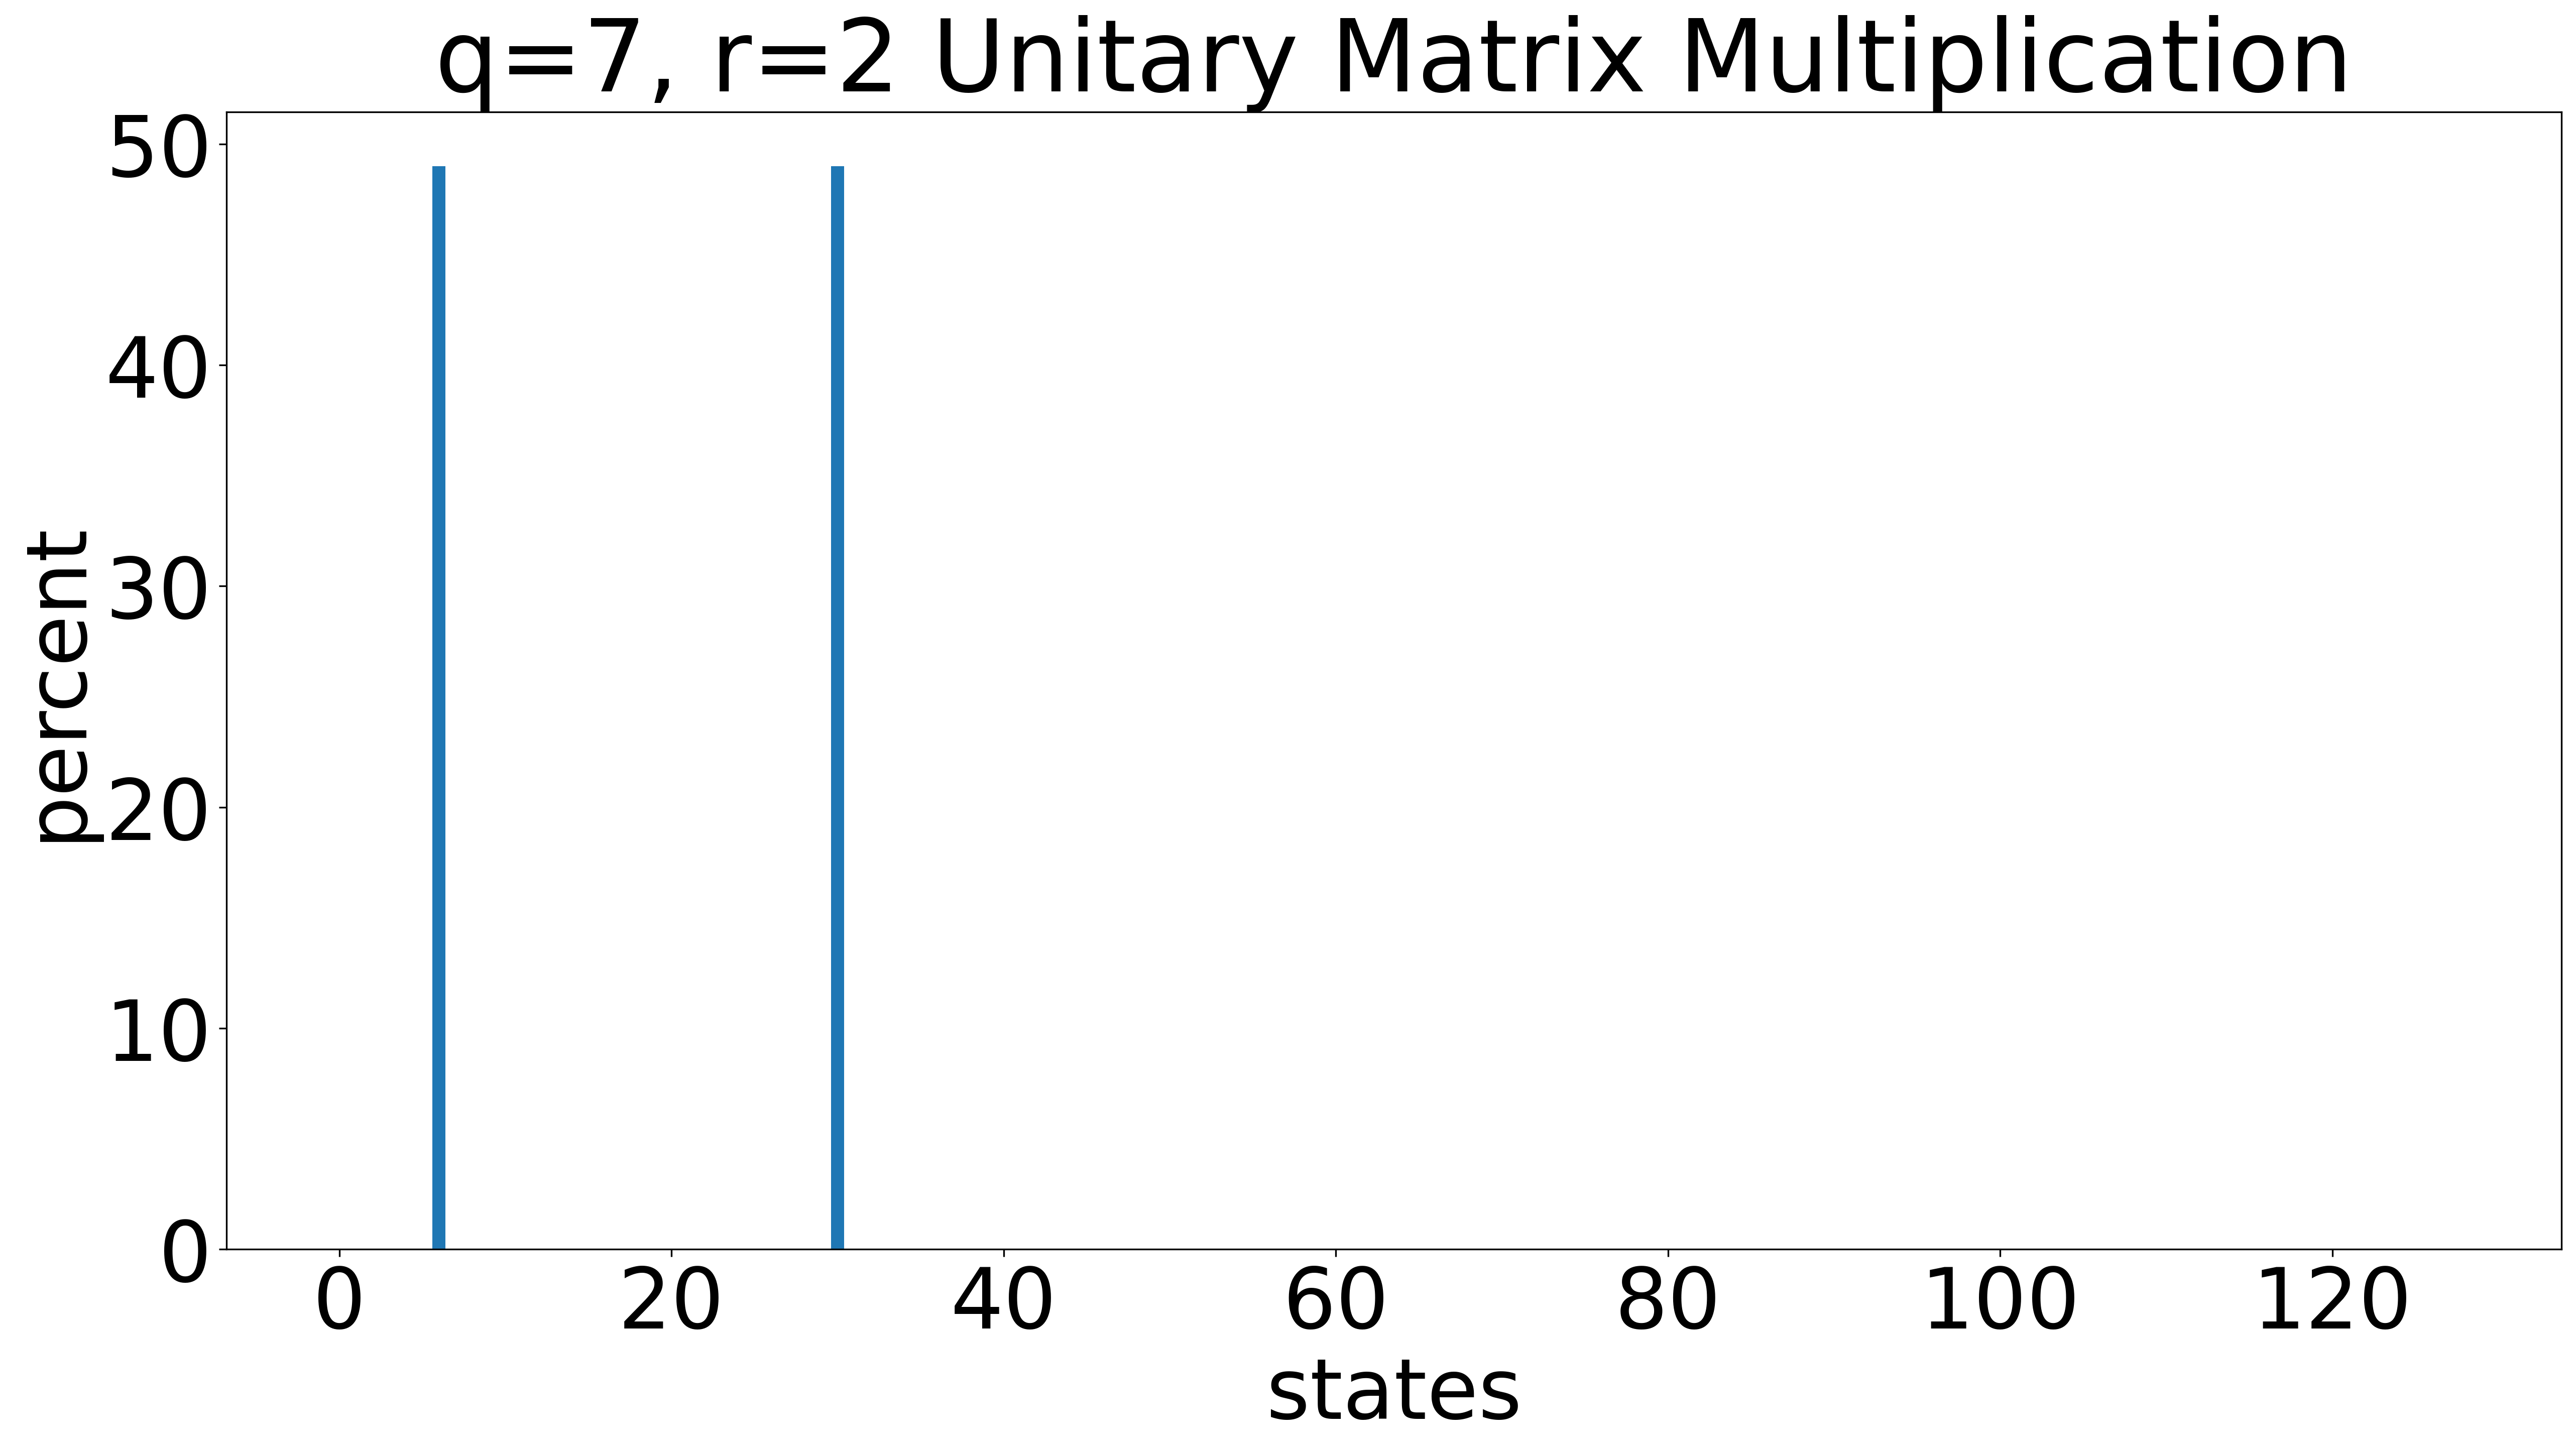

In [25]:
n=q
x_val=[]
y_val=[]
init_arr=np.zeros((2**n,1))
init_arr[0]=1
shots=1000
result=shots*np.square(np.abs(Ufinal @ init_arr))
y_val_t=(result.T.ravel())
for i in range (len(y_val_t)):
    y_val.append(int(100*y_val_t[i]/shots))
x_val=range(2**n)
x_index=np.argsort(x_val)
for i in (x_index):
    if y_val[i]>=1:
        print(x_val[i],':', y_val[i])
plt.bar(x_val, y_val)
plt.xlabel('states');
plt.ylabel('percent');
plt.title('q='+str(n)+', r='+str(r)+' Unitary Matrix Multiplication')
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 40})

plt.show()

Run the Unitary on the Local Simulator

In [26]:
targets=[]
circ_Ufinal=Circuit()
for i in range (n):
    targets.append(i)
circ_Ufinal=circ_Ufinal.unitary(matrix=Ufinal, targets=targets)
print(circ_Ufinal)

T  : |0|
        
q0 : -U-
      | 
q1 : -U-
      | 
q2 : -U-
      | 
q3 : -U-
      | 
q4 : -U-
      | 
q5 : -U-
      | 
q6 : -U-

T  : |0|


6 : 52
30 : 47


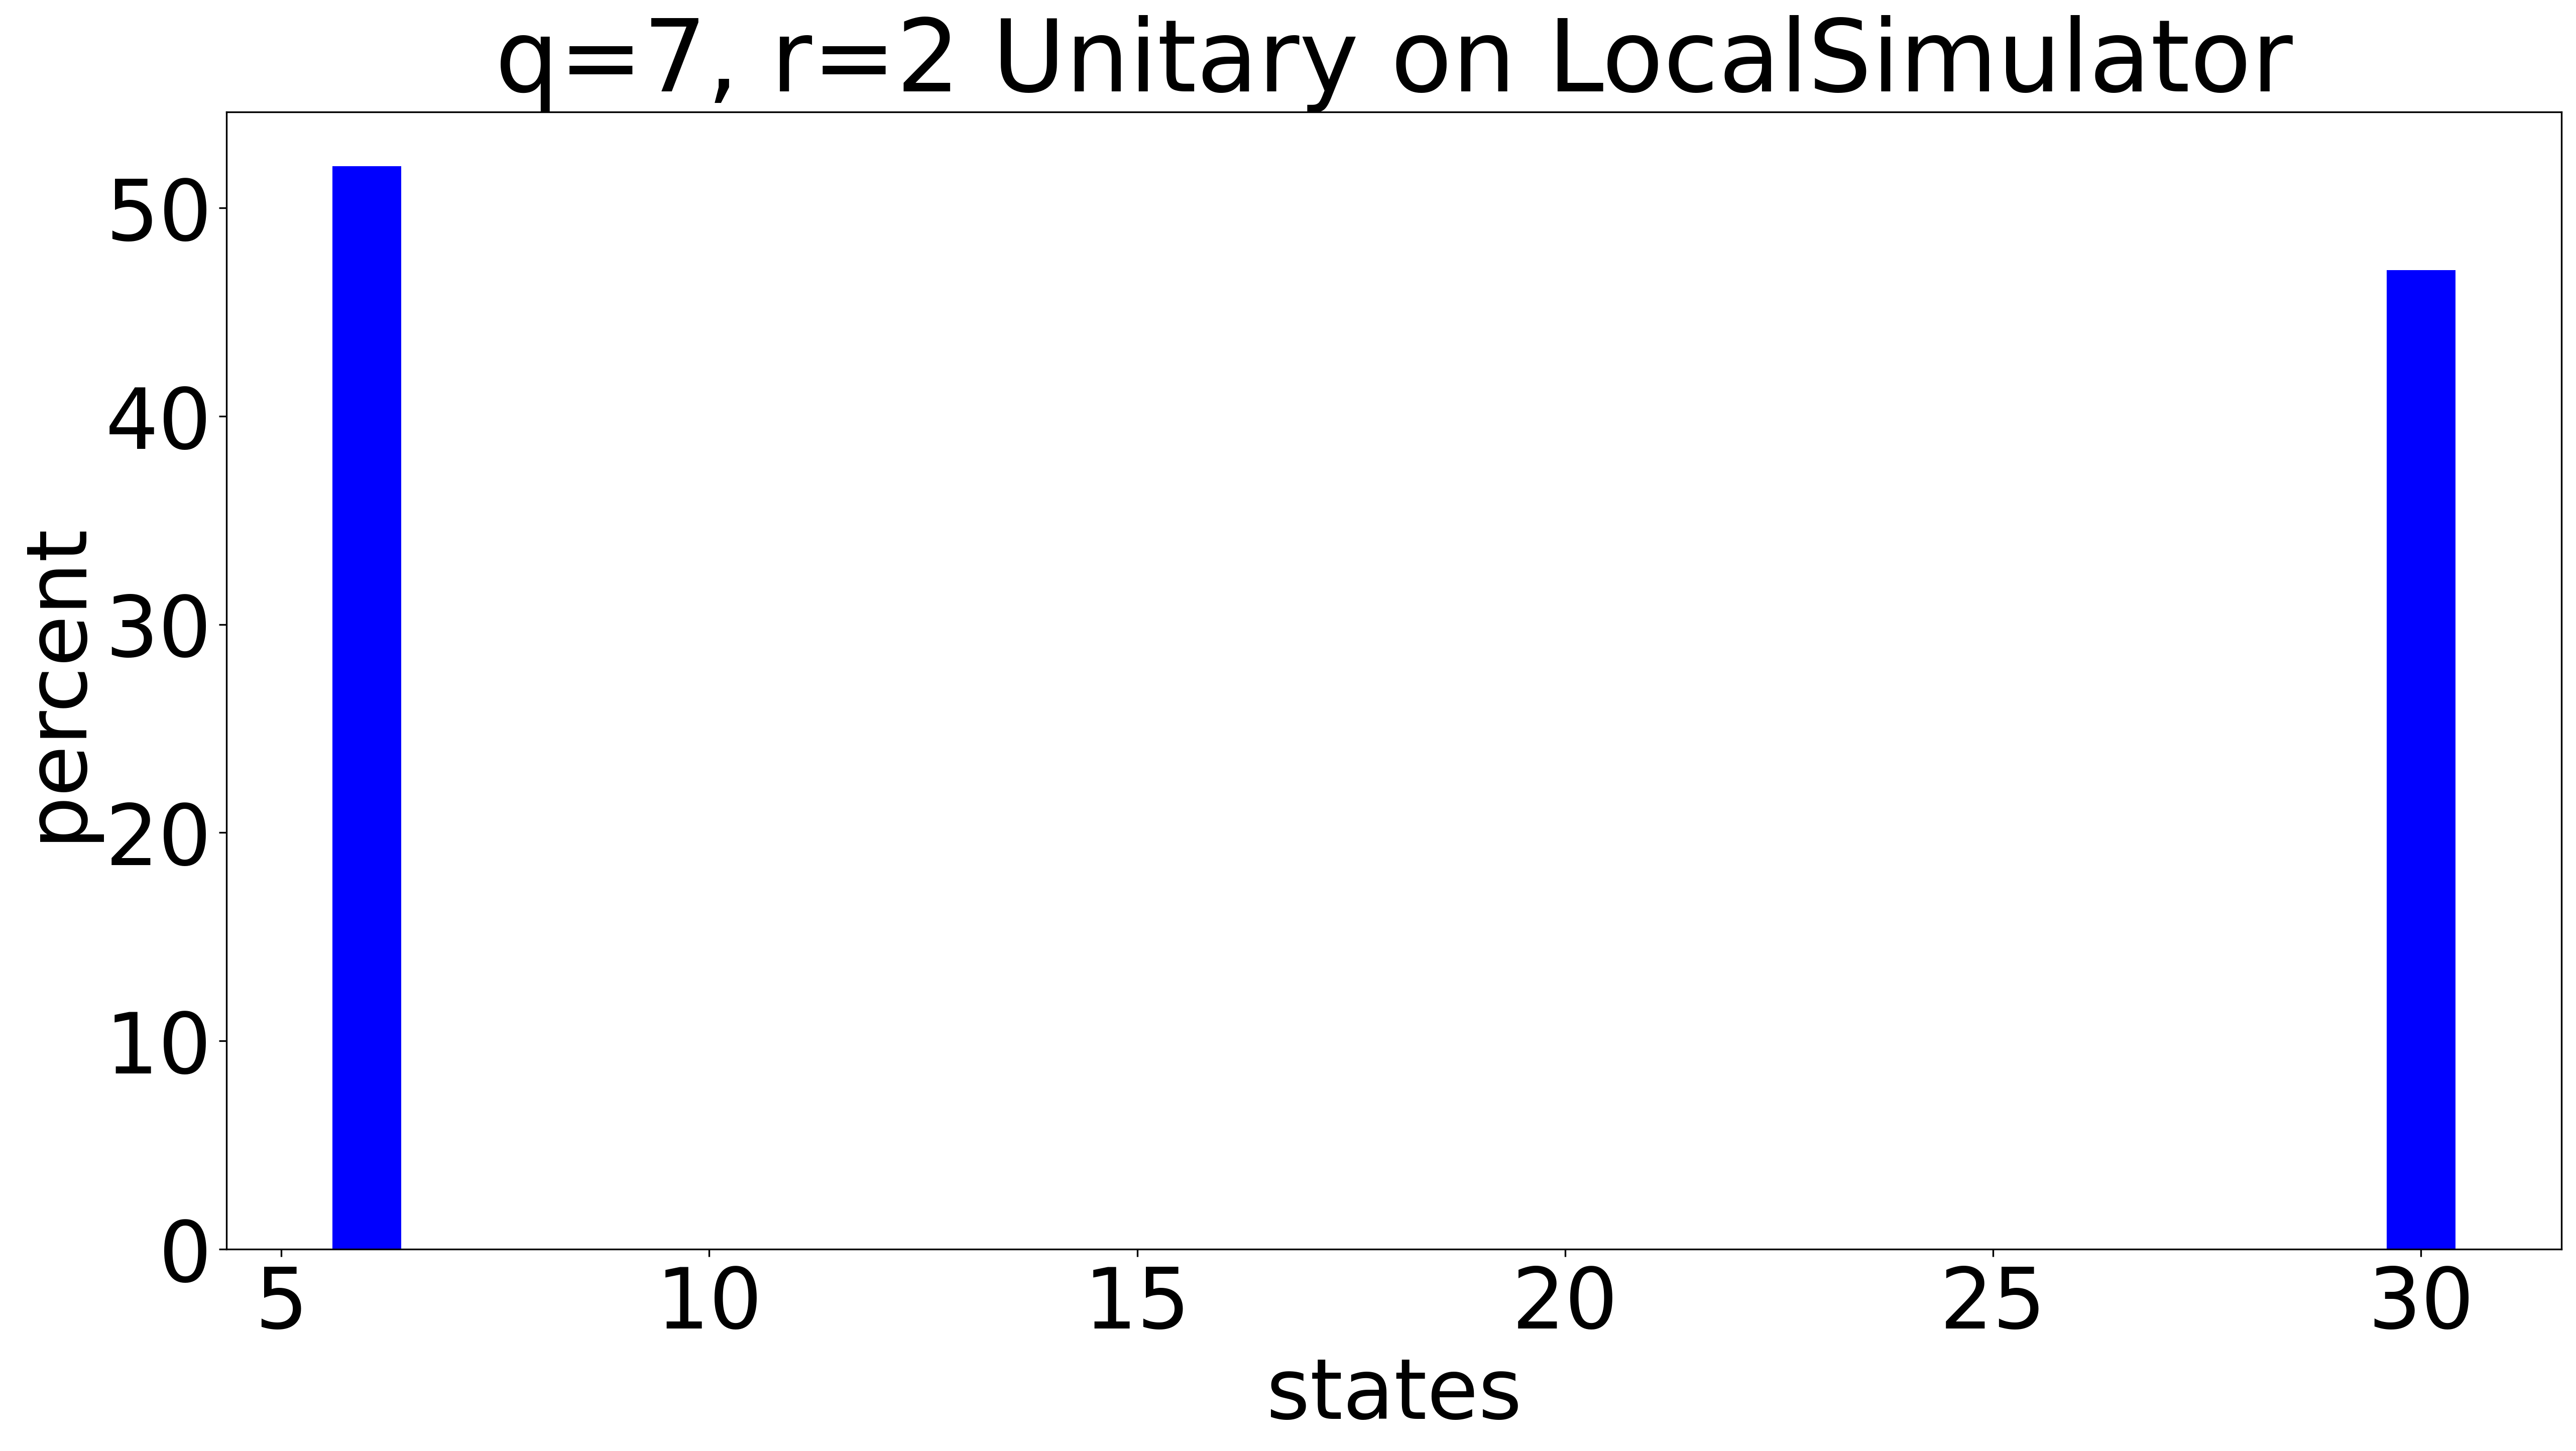

In [27]:
device = LocalSimulator()
shots=1000
result = device.run(circ_Ufinal, shots=shots).result()
counts = result.measurement_counts

#print(counts)
x_val=[]
y_val=[]
for i in (counts.keys()):
    x_val.append(int(i,2))

for i in (counts.values()):
    y_val.append(int(100*i/shots))

x_index=np.argsort(x_val)
for i in (x_index):
    if y_val[i]>=1:
        print(x_val[i],':', y_val[i])
plt.bar(x_val, y_val, color='b')
plt.title('q='+str(n)+', r='+str(r)+' Unitary on LocalSimulator')
plt.xlabel('states');
plt.ylabel('percent');
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['figure.dpi'] = 300
plt.show()

Run the gate based circuit on the Local Simulator

6 : 48
30 : 52


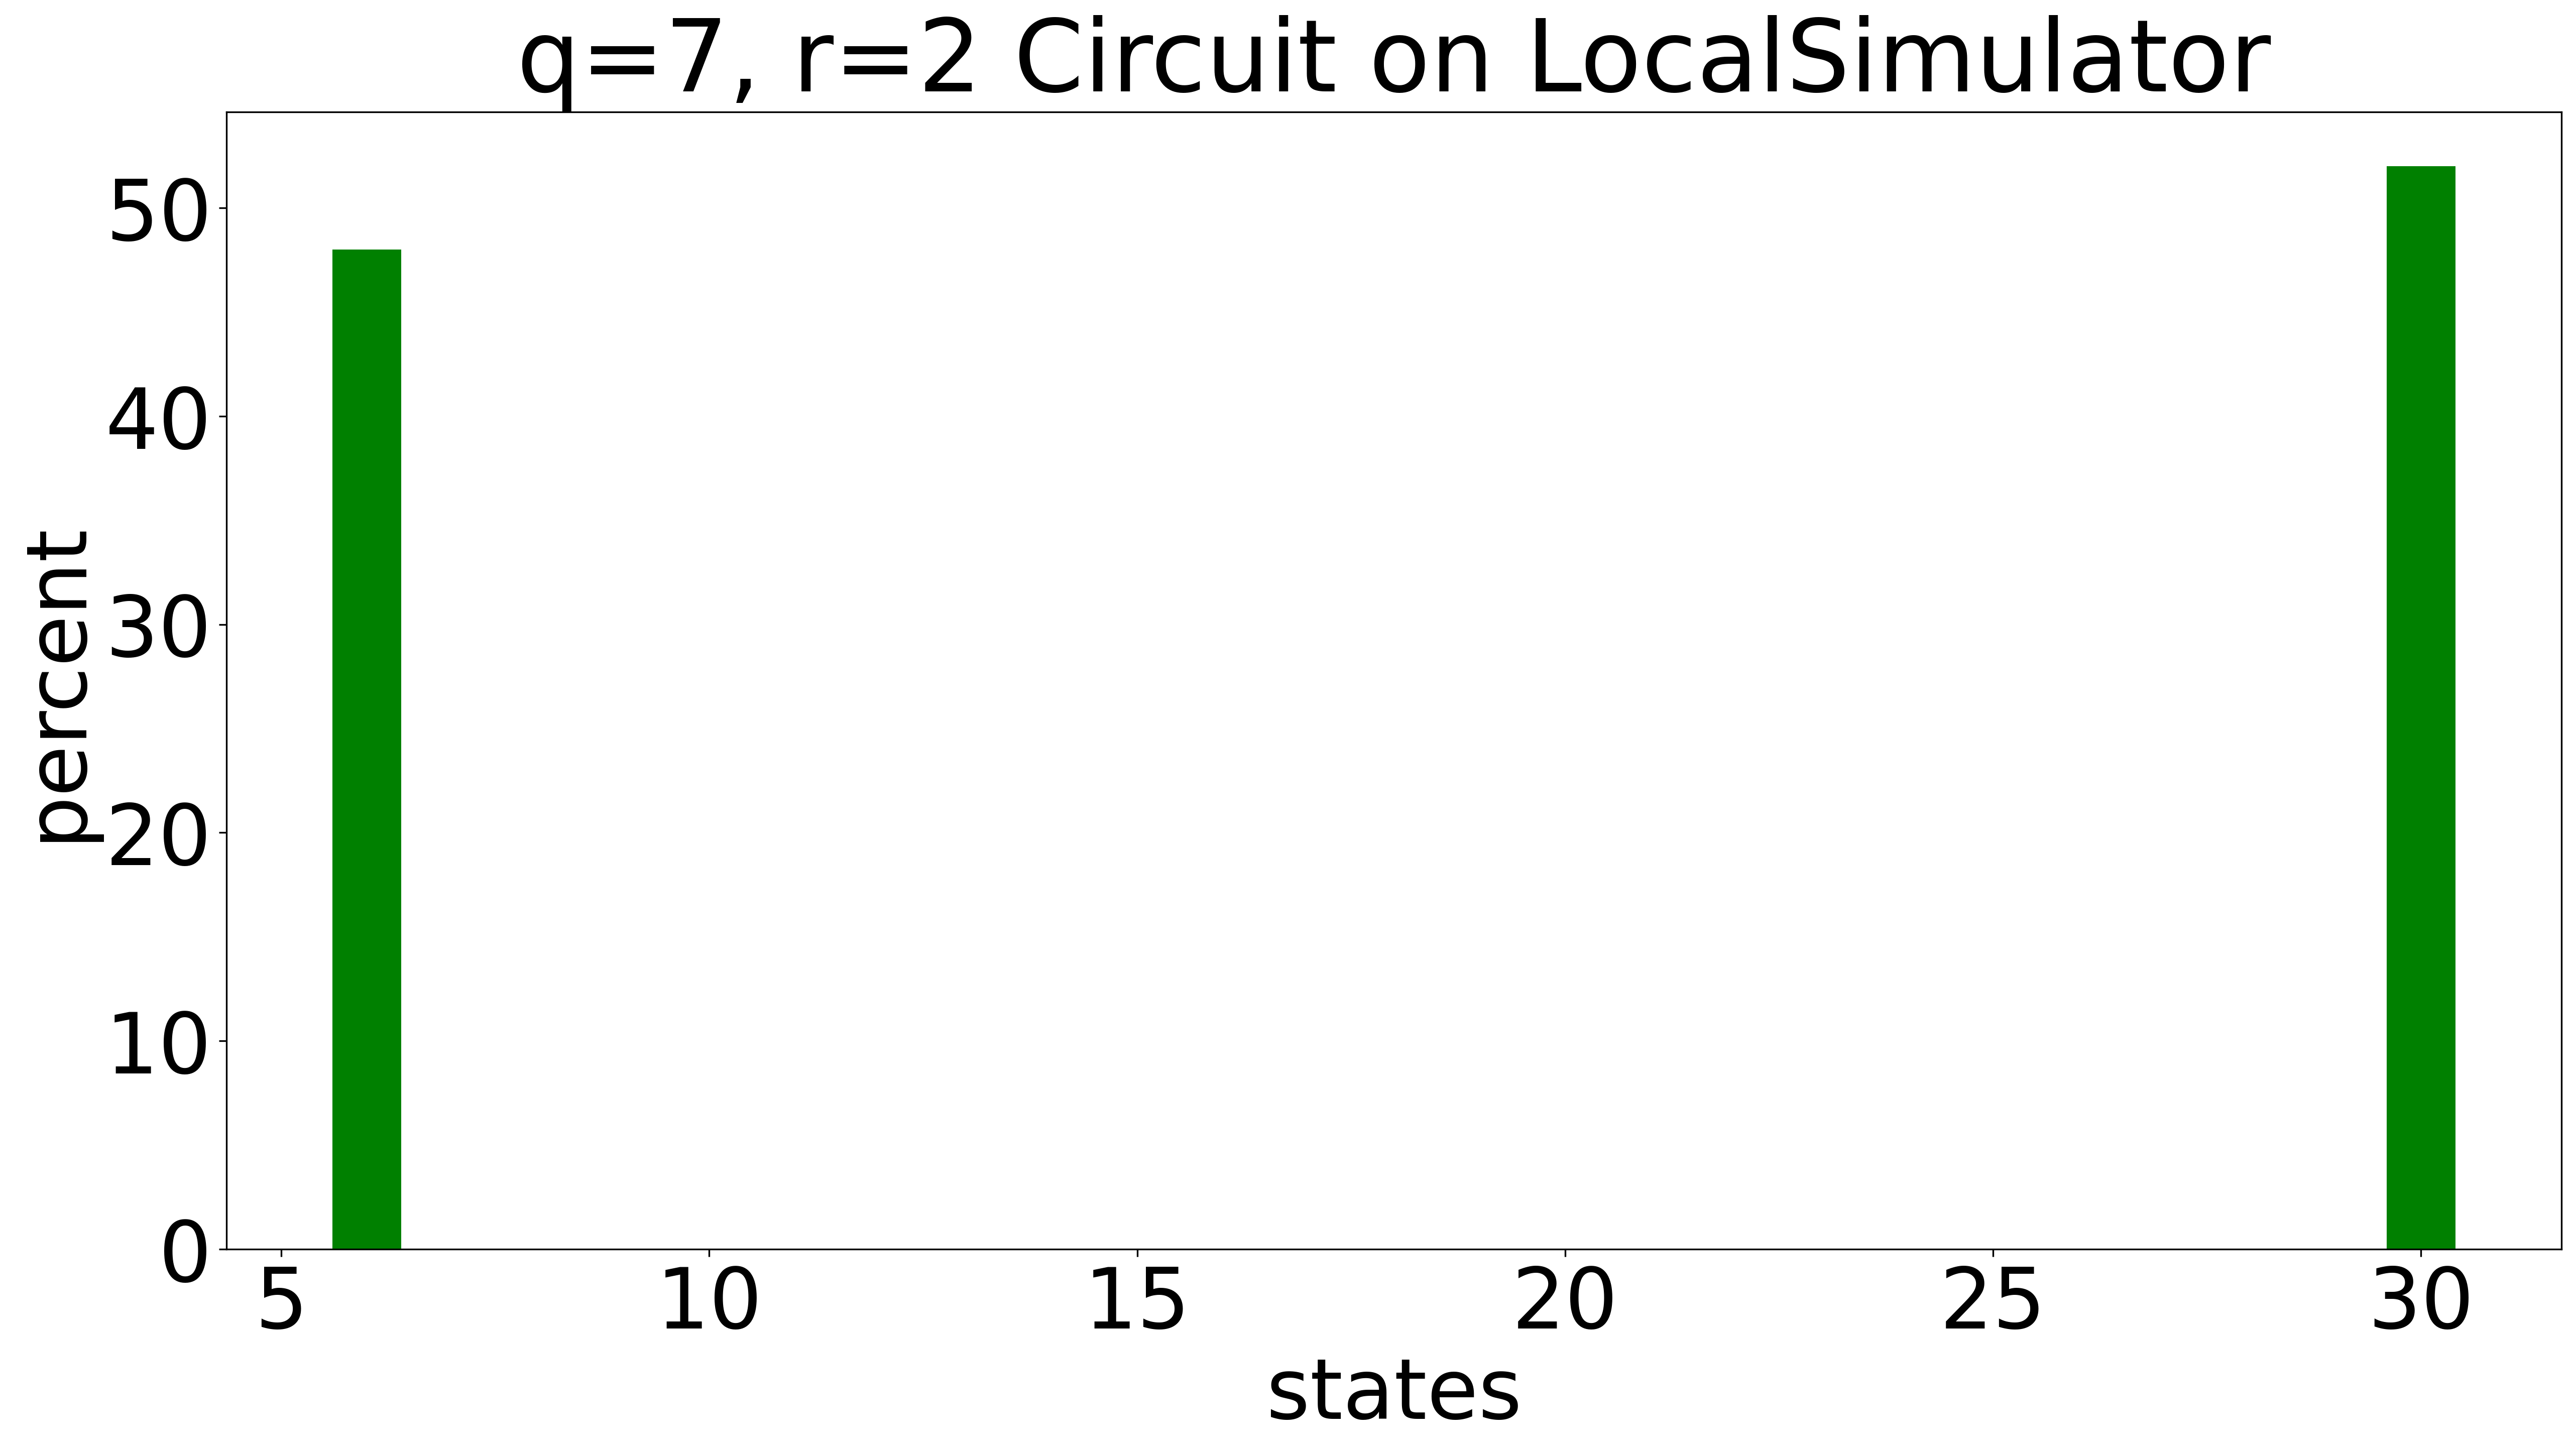

In [28]:
device = LocalSimulator()
shots=1000
result = device.run(g_circ, shots=shots).result()
#result = device.run(circ_Ufinal, shots=shots).result()
counts = result.measurement_counts
#print(counts)
x_val=[]
y_val=[]
for i in (counts.keys()):
    x_val.append(int(i,2))
for i in (counts.values()):
    y_val.append(int(100*i/shots))

x_index=np.argsort(x_val)
for i in (x_index):
    if y_val[i]>=1:
        print(x_val[i],':', y_val[i])
plt.bar(x_val, y_val, color='g')
plt.title('q='+str(n)+', r='+str(r)+' Circuit on LocalSimulator')
plt.xlabel('states');
plt.ylabel('percent');
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['figure.dpi'] = 300
plt.show()

Now run on various devices

In [29]:
available_devices()

['Advantage_system1.1',
 'Aspen-9',
 'DW_2000Q_6',
 'IonQ Device',
 'SV1',
 'TN1',
 'dm1']

In [30]:
device_name='SV1'
device=set_device(device_name)
estimate_cost(device)


Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
simulator cost per  minute : $ 0.075
total cost cannot be estimated


In [31]:
shots=estimate_cost_measured_qubits(device, n)

max shots: 100000
for 7 measured qubits the number of shots recommended: 3,200
simulator cost per  minute : $ 0.075
total cost cannot be estimated


Run the unitary matrix on the device

6 : 50
30 : 49


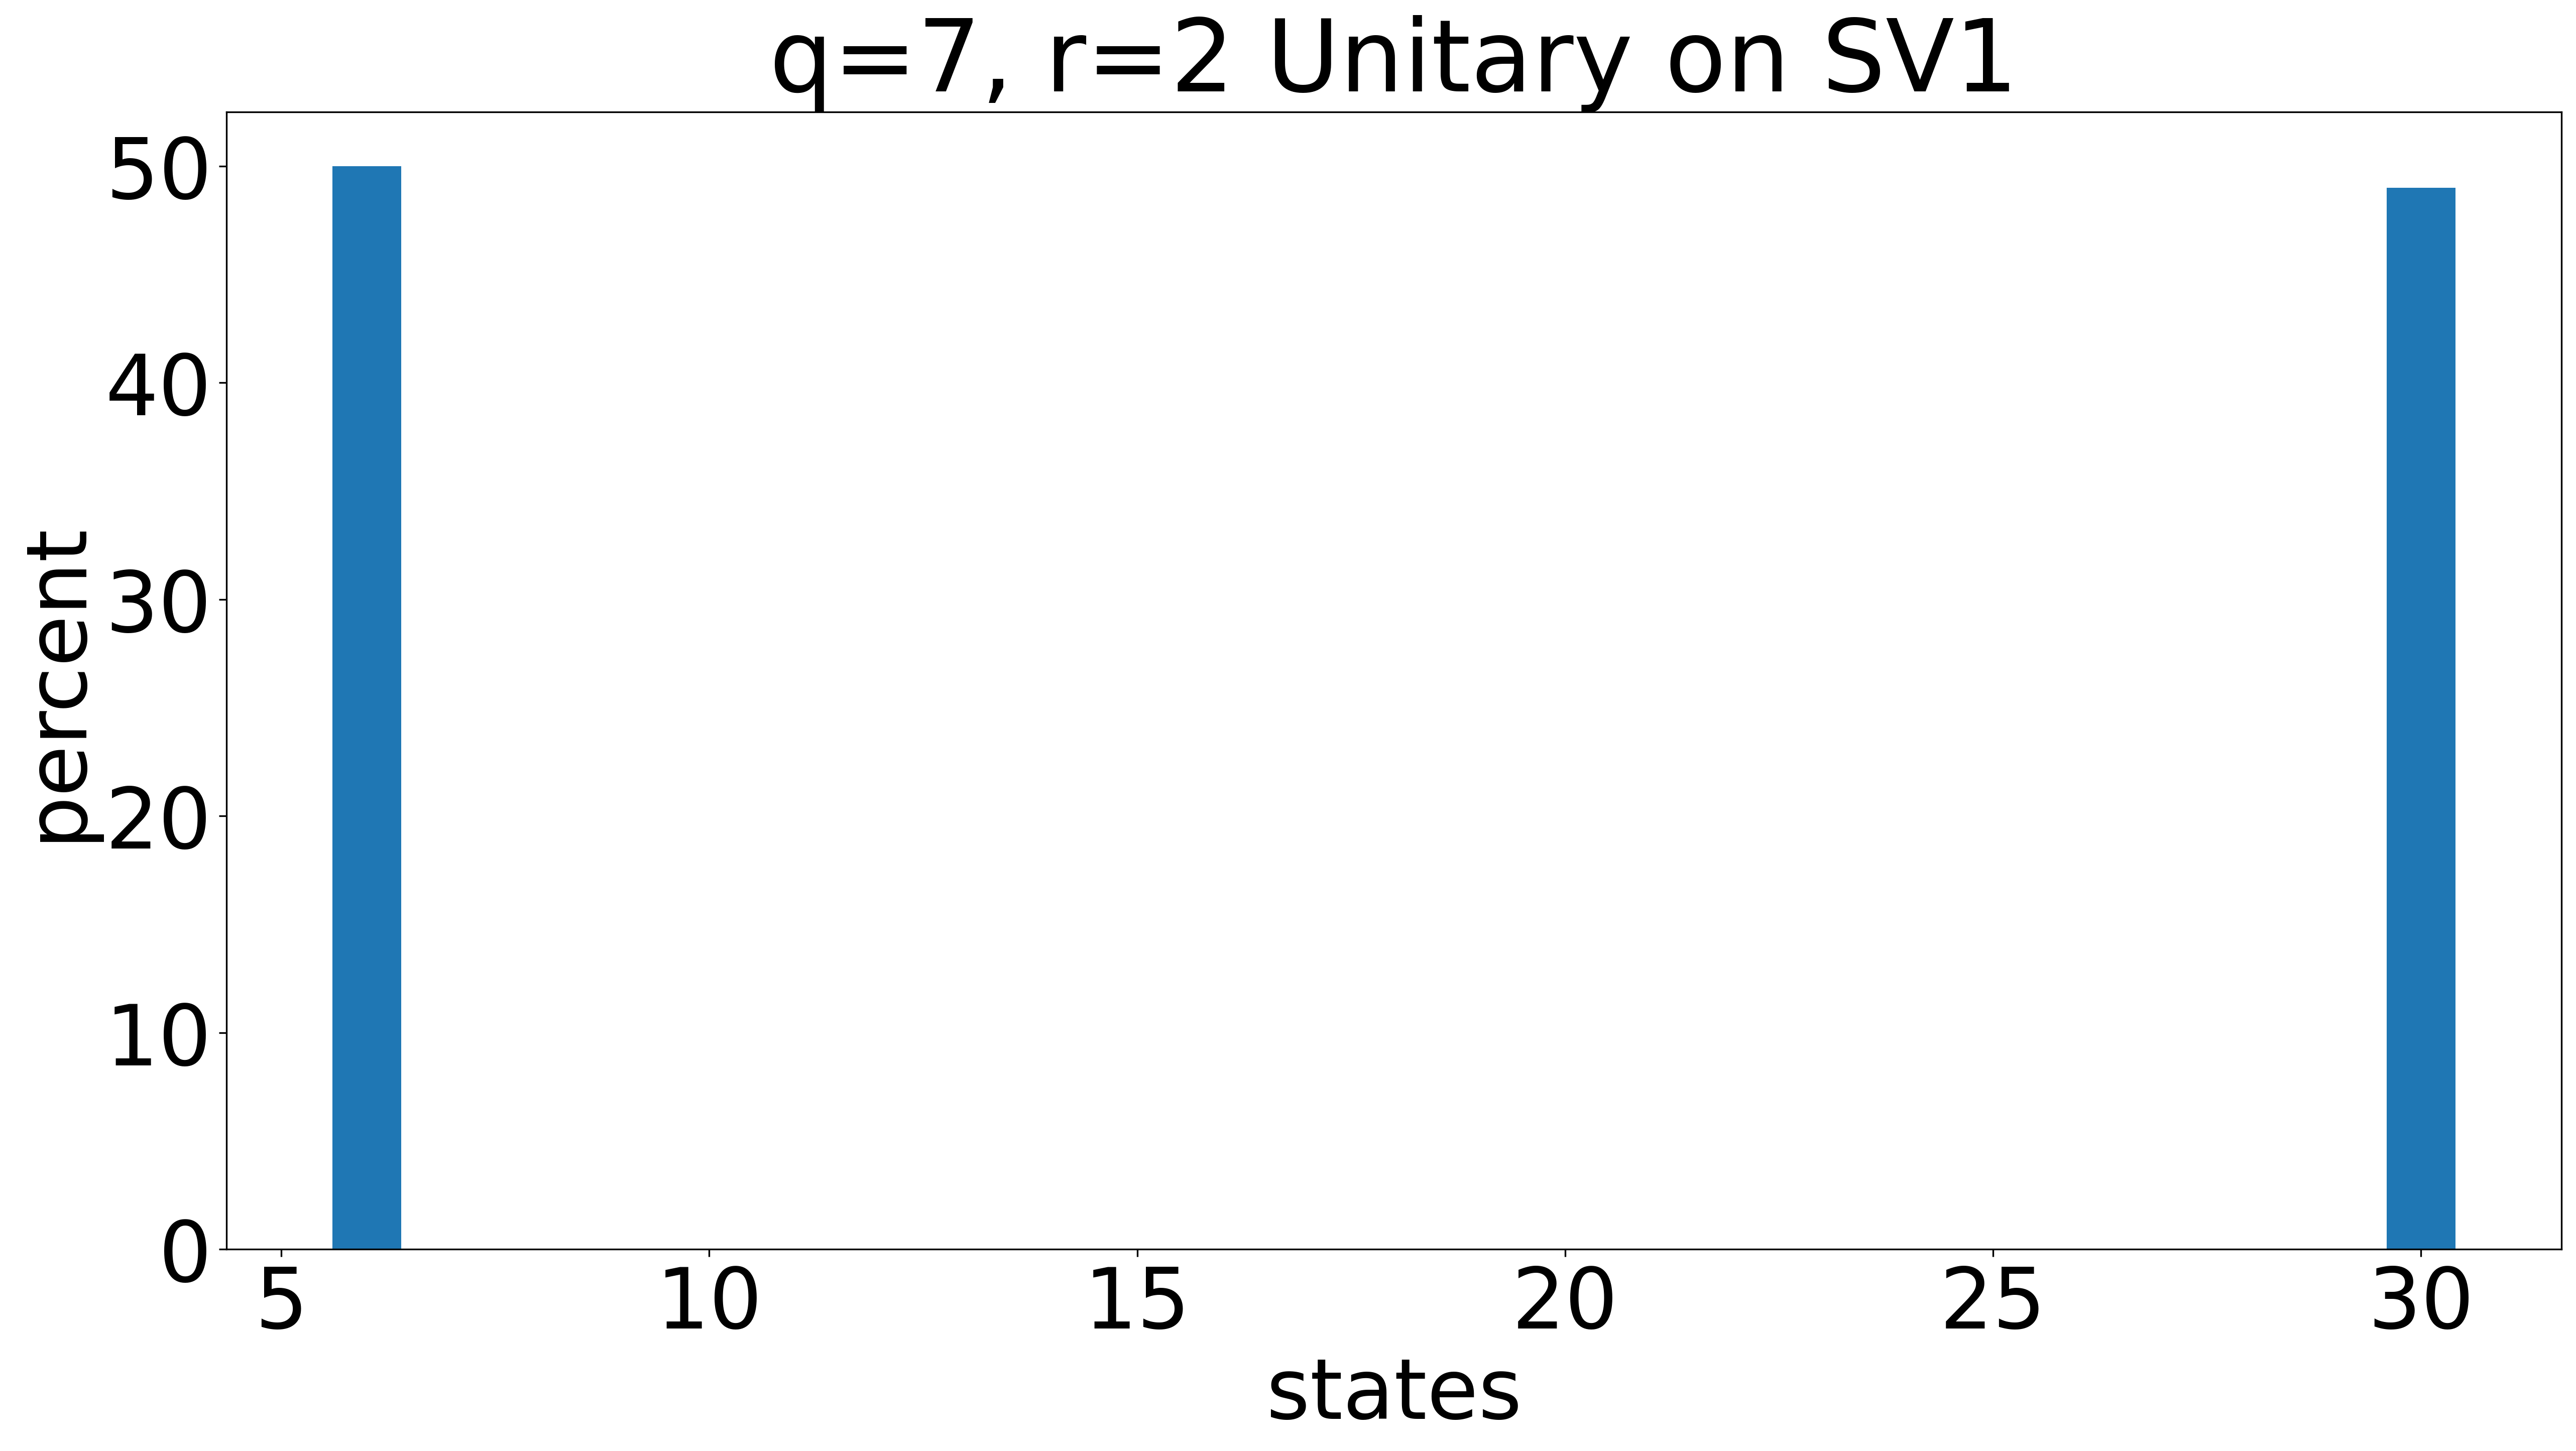

In [32]:
title='q='+str(n)+', r='+str(r)+' Unitary on '+device_name
result=run_circuit(device, circ_Ufinal, shots, s3_folder, title, False)


In [33]:
actual_simulator_cost(device, result)

simulator cost per  minute : $ 0.075
total execution time:  131 ms
total cost estimated: $ 0.00016375000000000002


Run the full quantum gate circuit on the device

6 : 50
30 : 49


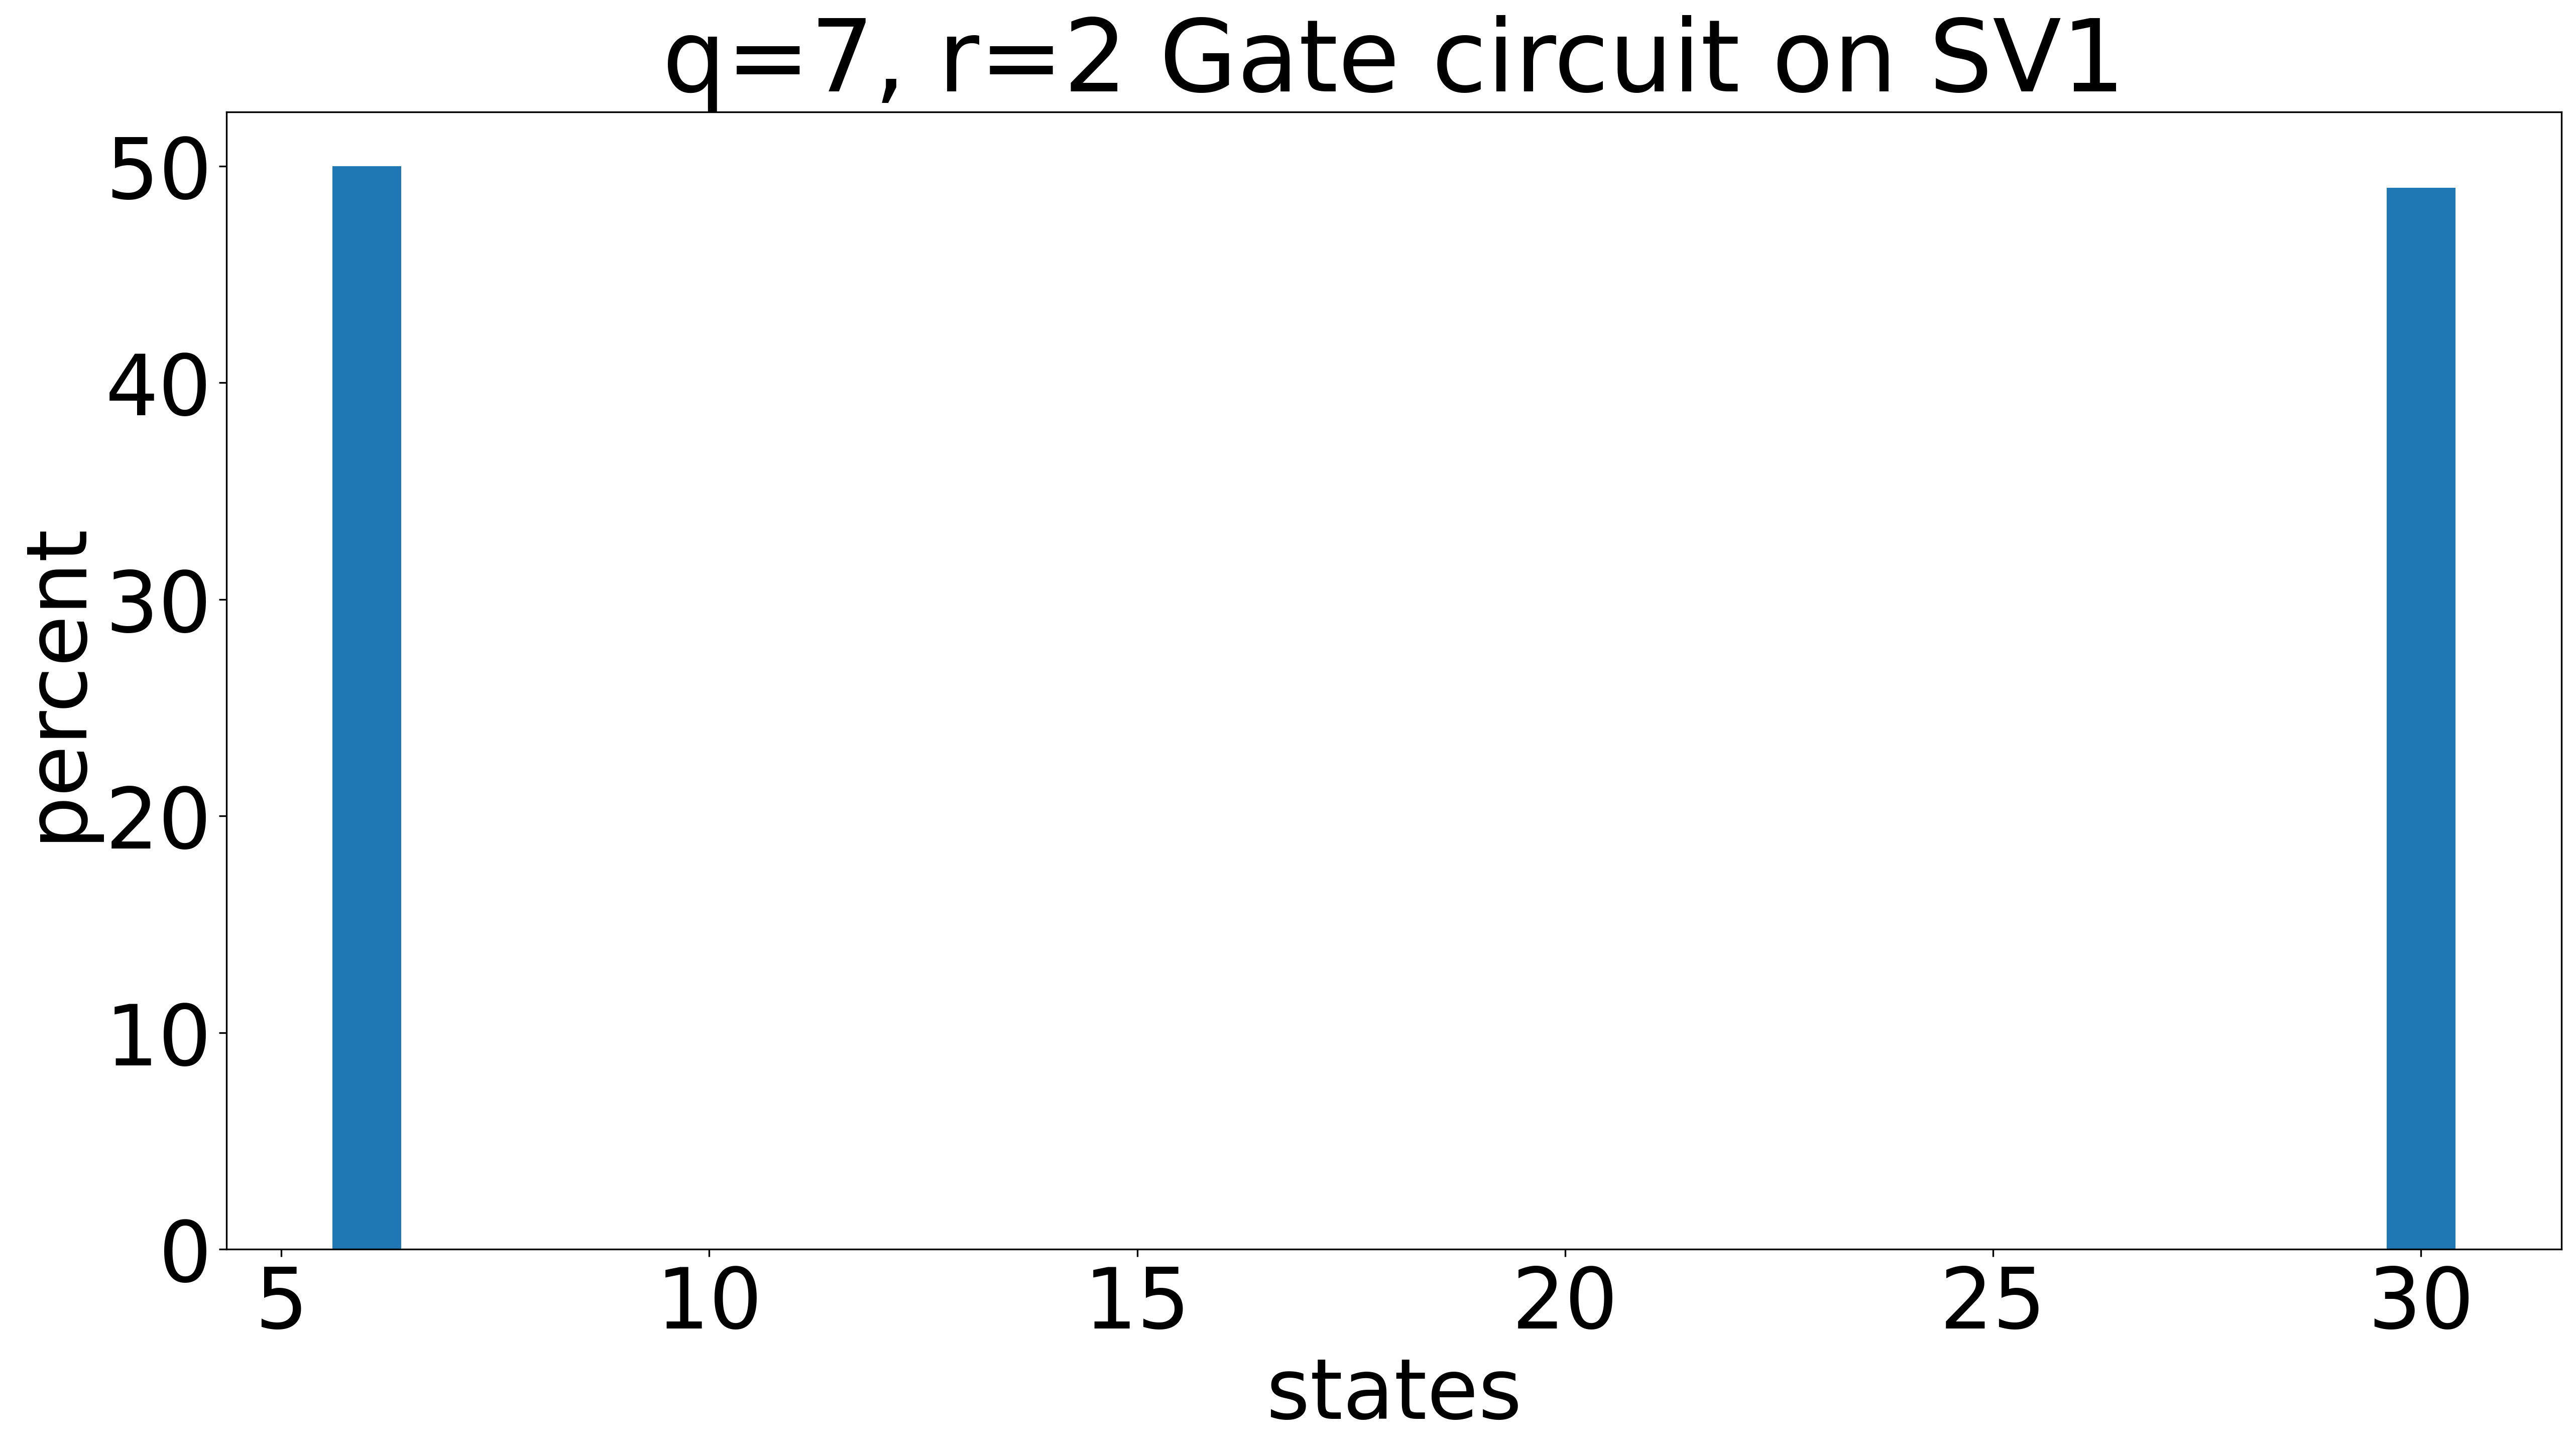

In [34]:
title='q='+str(n)+', r='+str(r)+' Gate circuit on '+device_name
result=run_circuit(device, g_circ, shots, s3_folder, title, False)

In [35]:
actual_simulator_cost(device, result)

simulator cost per  minute : $ 0.075
total execution time:  22 ms
total cost estimated: $ 2.75e-05


Run the quantum circuit on TN1

In [36]:
device_name='TN1'
device=set_device(device_name)
estimate_cost(device)


Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
simulator cost per  minute : $ 0.275
total cost cannot be estimated


In [37]:
shots=estimate_cost_measured_qubits(device, n)

max shots: 1000
for 7 measured qubits the maximum allowed shots: 1,000
simulator cost per  minute : $ 0.275
total cost cannot be estimated


6 : 49
30 : 50


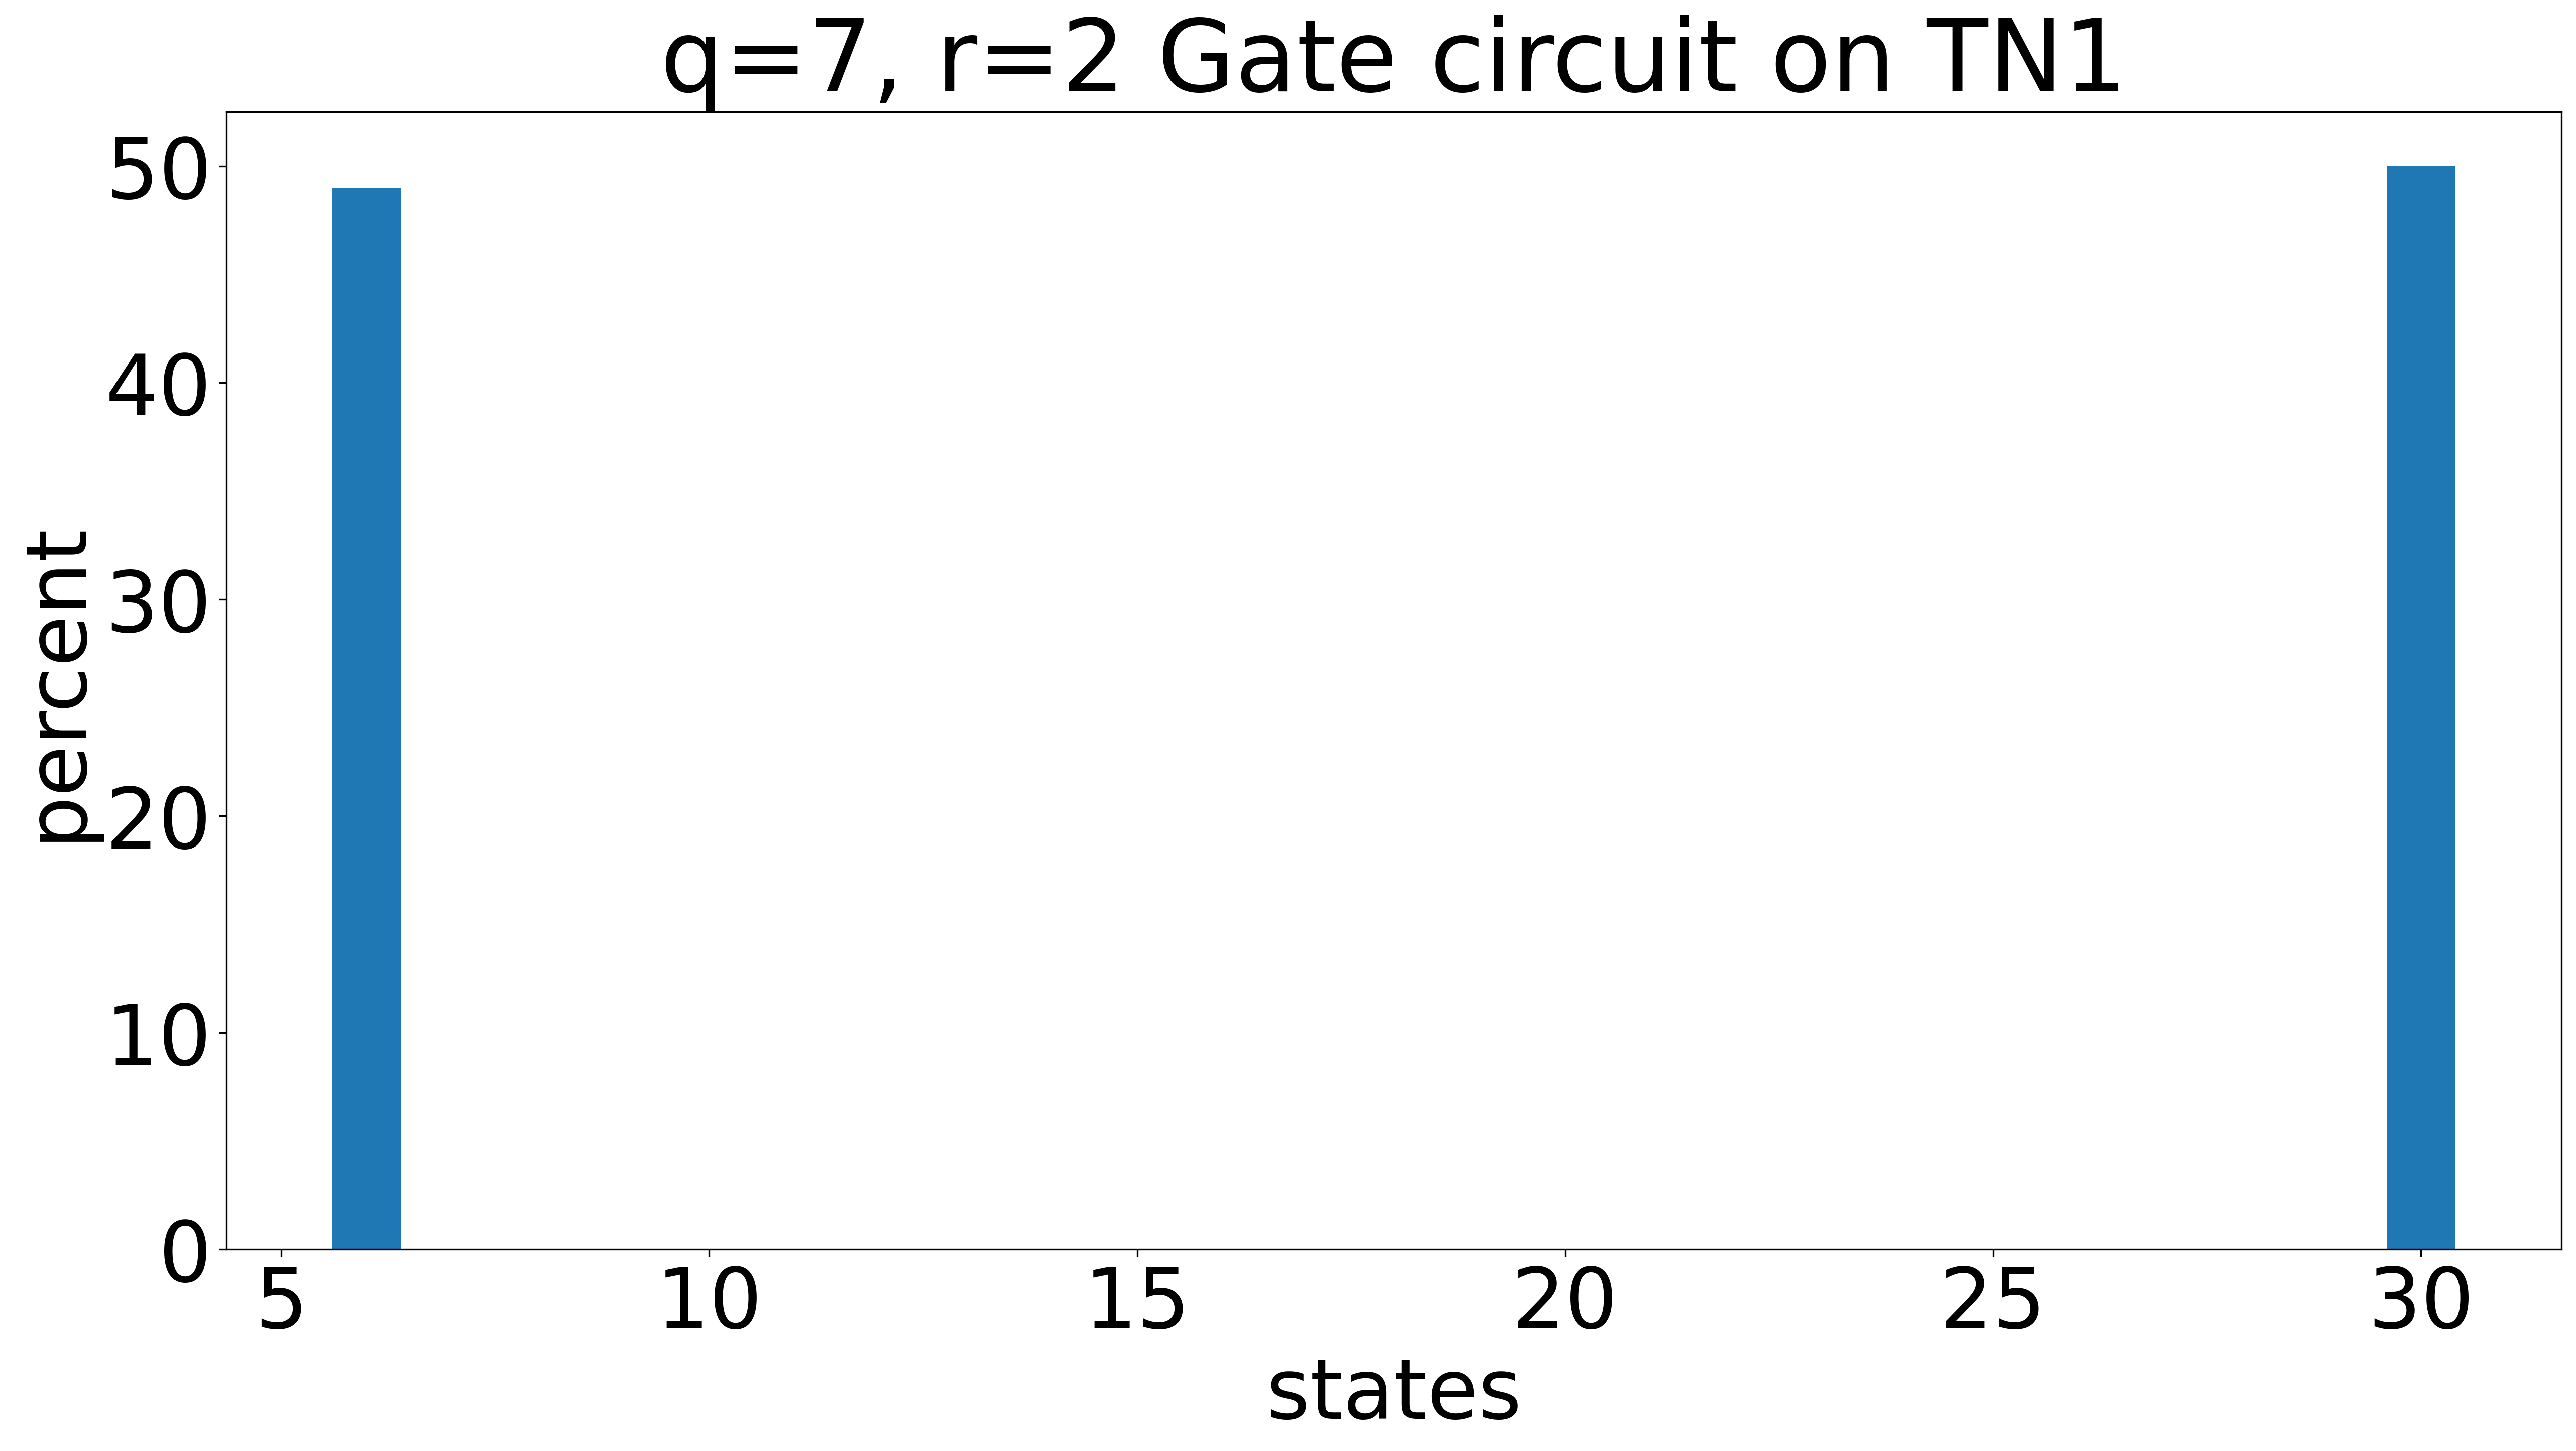

In [38]:
title='q='+str(n)+', r='+str(r)+' Gate circuit on '+device_name
result=run_circuit(device, g_circ, shots, s3_folder, title, False)

In [39]:
actual_simulator_cost(device, result)

simulator cost per  minute : $ 0.275
total execution time:  7329 ms
total cost estimated: $ 0.033591249999999996


In [40]:
device_name='IonQ Device'
device=set_device(device_name)
estimate_cost(device)

Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
device cost per  shot : $ 0.01
total cost for 1000 shots is $10.30


In [41]:
shots=estimate_cost_measured_qubits(device, n)

max shots: 10000
for 7 measured qubits the number of shots recommended: 3,200
device cost per  shot : $ 0.01
total cost for 3200 shots is $32.30


0 : 1
2 : 2
6 : 44
14 : 1
22 : 2
26 : 2
30 : 36
38 : 1


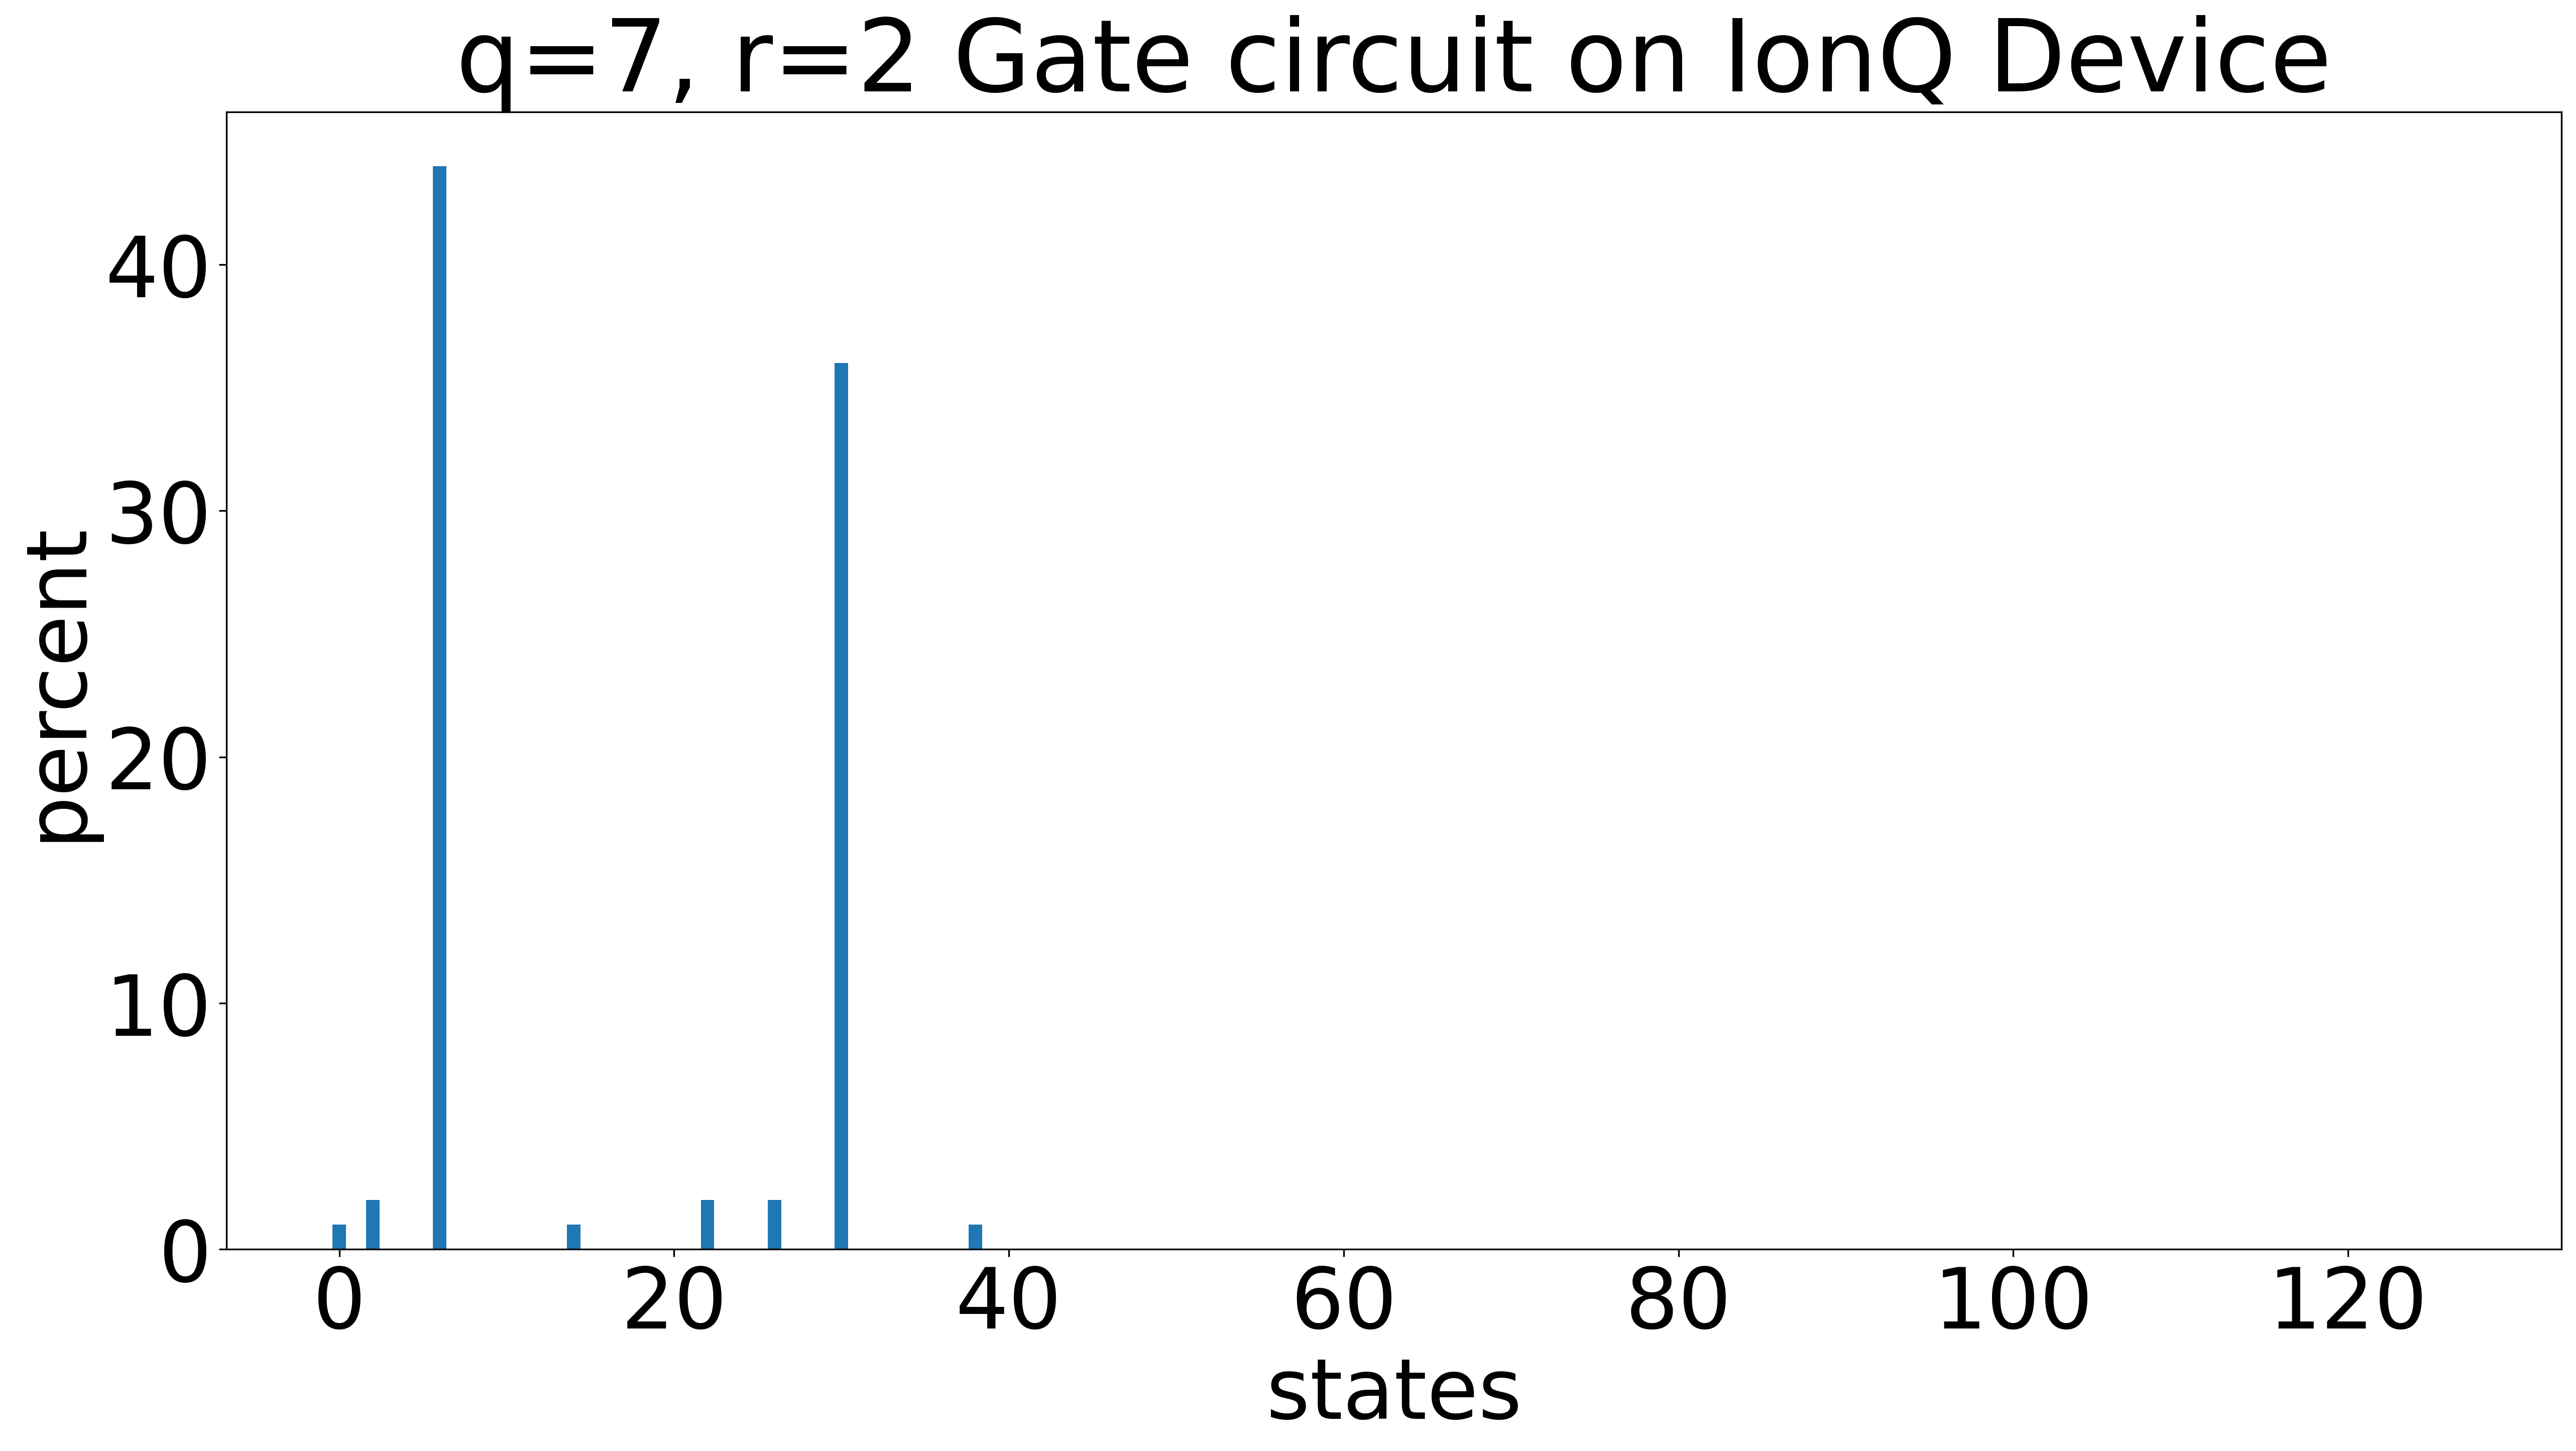

In [42]:
title='q='+str(n)+', r='+str(r)+' Gate circuit on '+device_name
result=run_circuit(device, g_circ, shots, s3_folder, title, False)

In [43]:
device_name='Aspen-9'
device=set_device(device_name)
estimate_cost(device)

Device('name': Aspen-9, 'arn': arn:aws:braket:::device/qpu/rigetti/Aspen-9)
device cost per  shot : $ 0.00035
total cost for 1000 shots is $0.65


In [44]:
shots=estimate_cost_measured_qubits(device, n)

max shots: 100000
for 7 measured qubits the number of shots recommended: 3,200
device cost per  shot : $ 0.00035
total cost for 3200 shots is $1.42


0 : 1
2 : 1
6 : 7
7 : 3
14 : 2
15 : 1
18 : 1
22 : 2
23 : 1
28 : 1
30 : 7
31 : 3
38 : 1
46 : 1
62 : 1
70 : 4
71 : 2
78 : 1
86 : 1
94 : 4
95 : 2
102 : 1
110 : 1
118 : 1
126 : 1


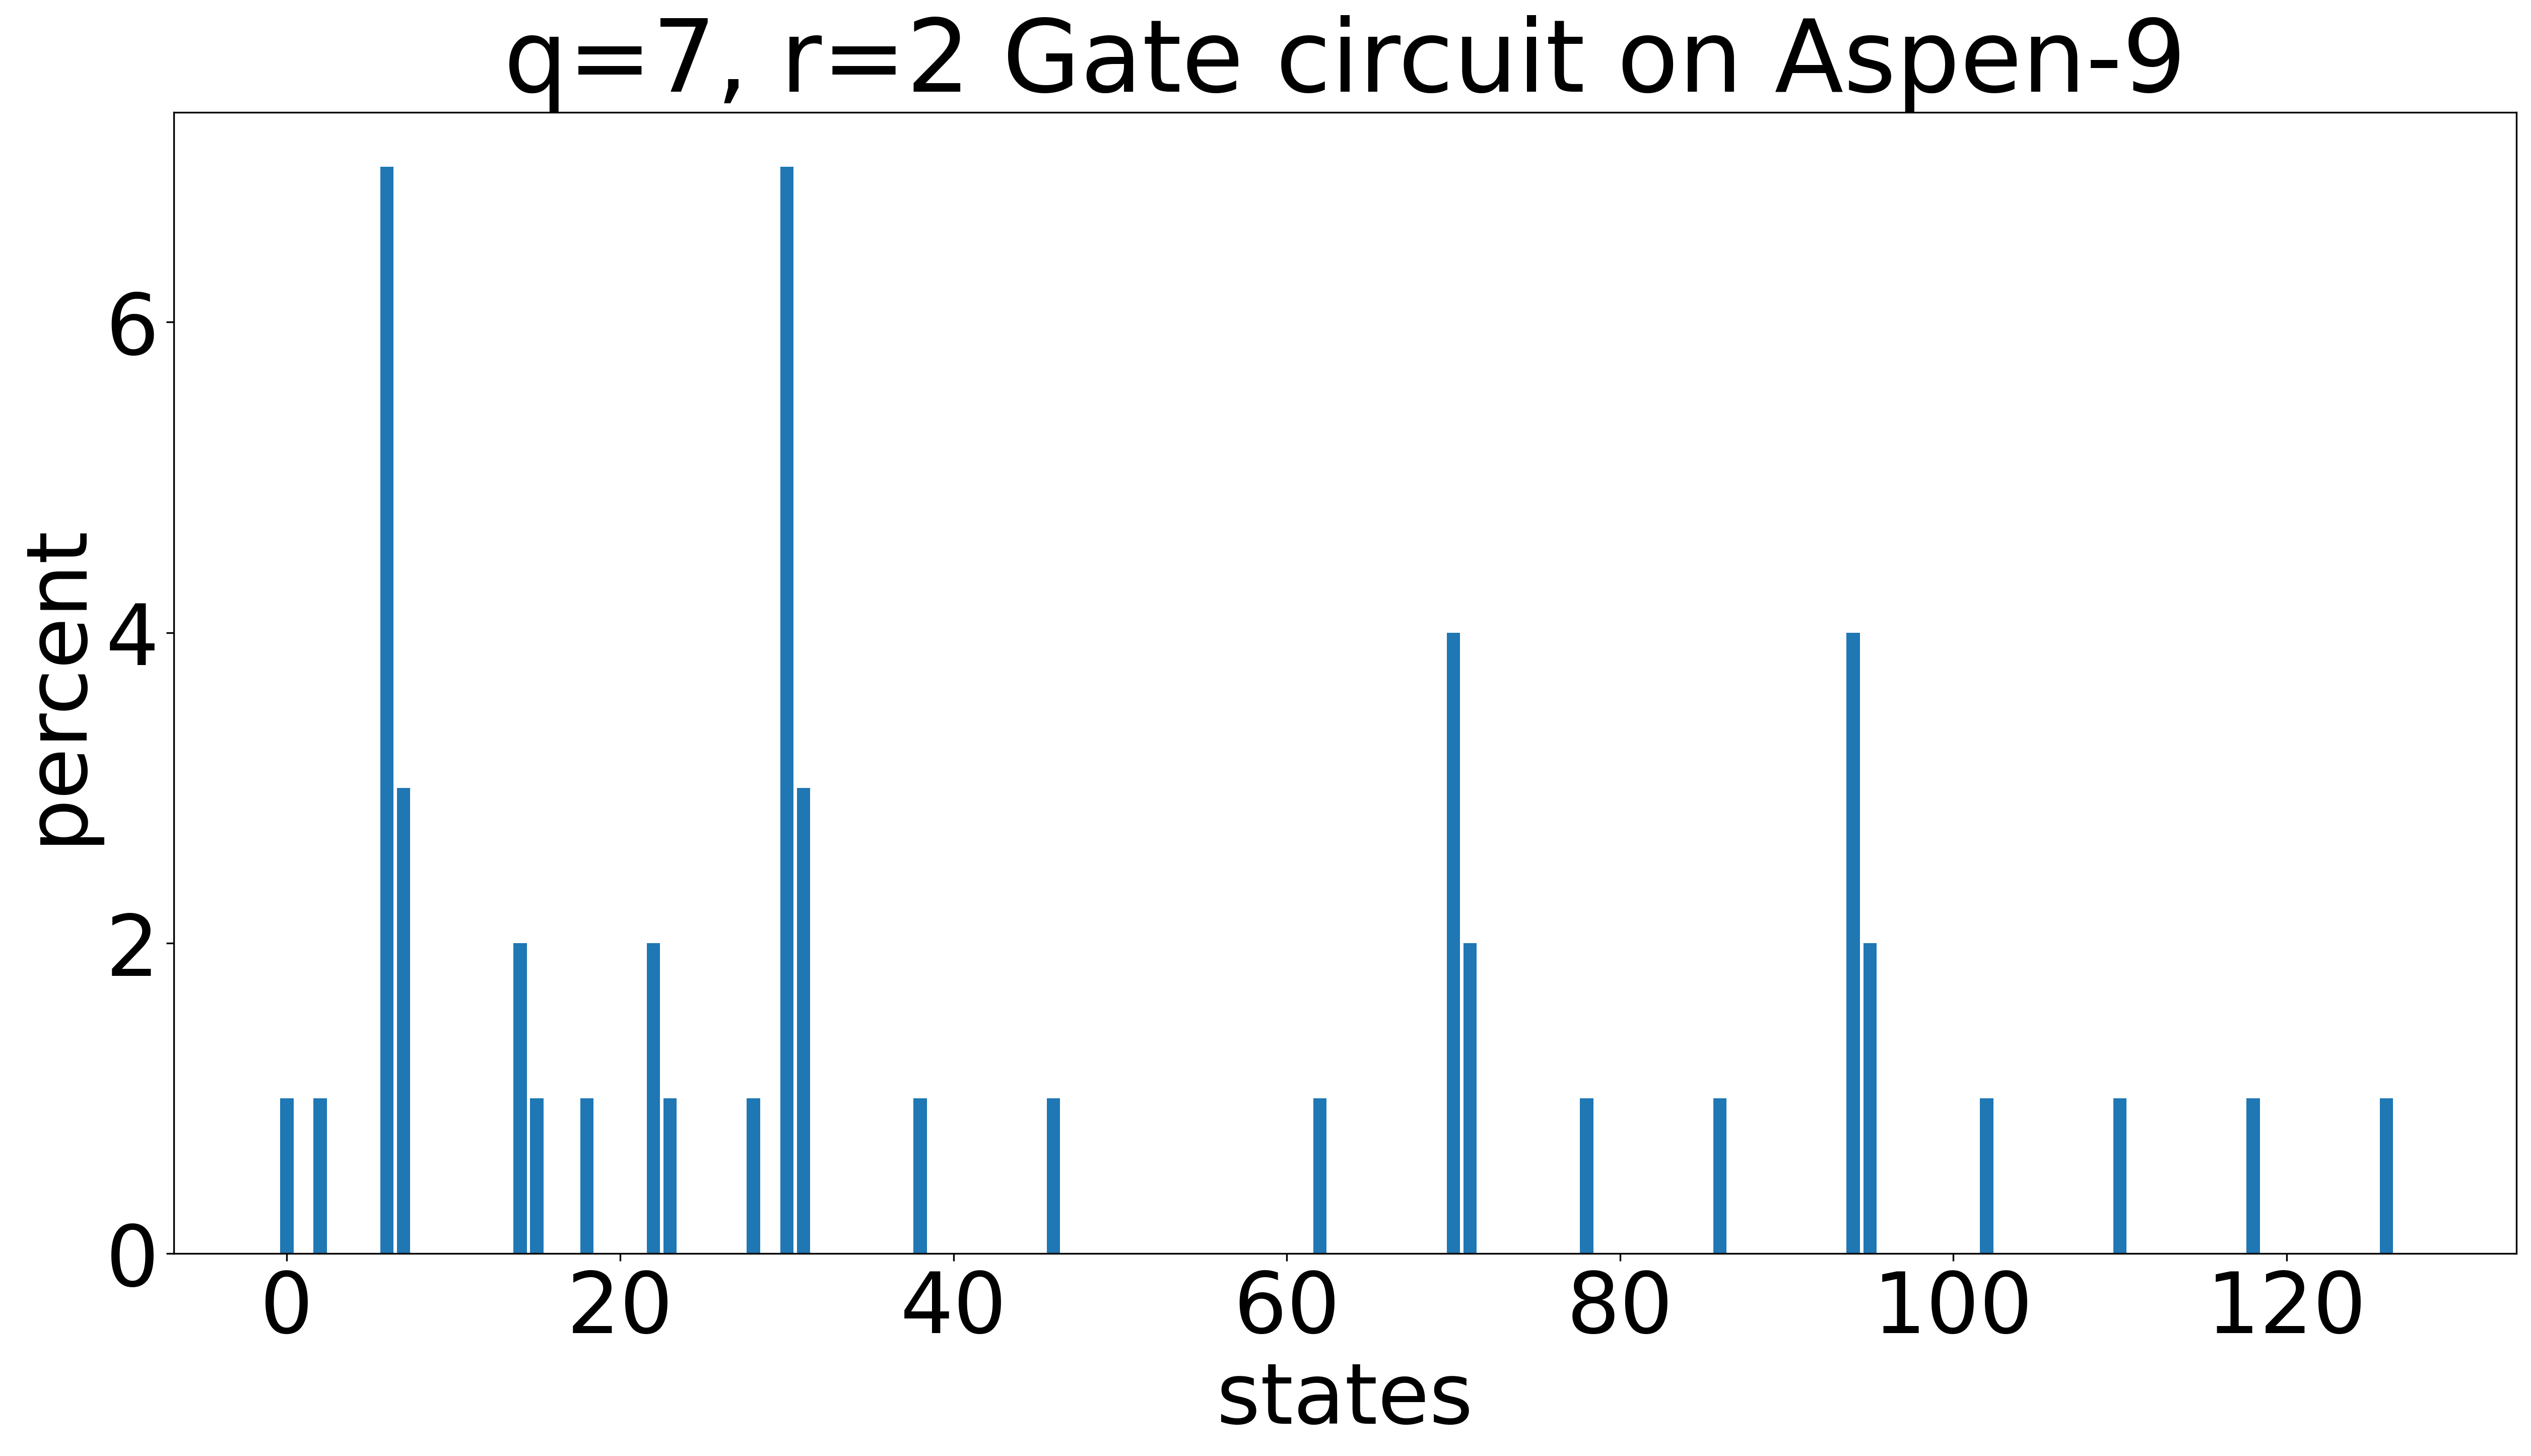

In [45]:
title='q='+str(n)+', r='+str(r)+' Gate circuit on '+device_name
result=run_circuit(device, g_circ, shots, s3_folder, title, False)

Below is some additional sample code and test runs

In [15]:
# 1. timing test
import datetime
for q in range (10,14):
    for r in range (2,10):
        start_time = datetime.datetime.now()
        Ufinal, g_circ=qc_rand(q,r)
        duration_build_matrix = datetime.datetime.now()-start_time
        print(q,r,duration_build_matrix)

In [ ]:
Sample Output:
13 2 0:03:18.886282
13 3 0:05:00.609652
13 4 0:06:25.538520
13 5 0:08:00.337110
13 6 0:09:19.879655

In [1]:
# 2. SV1 large circuit run
q=34
r=50

Ufinal, g_circ=qc_rand(q,r, matrix=False)
device_name='SV1'
device=set_device(device_name)
estimate_cost(device)
shots=estimate_cost_measured_qubits(device, q)
title='q='+str(q)+', r='+str(r)+' Gate circuit on '+device_name
result=run_circuit(device, g_circ, shots, s3_folder, title, False)
actual_simulator_cost(device, result)

In [ ]:
Output:
simulator cost per  minute : $ 0.075
total execution time:  11213540 ms
total cost estimated: $ 14.016925

In [ ]:
# 3. Maximum run on TN1
import datetime
q=50
r=49

start_time = datetime.datetime.now()

Ufinal, g_circ=qc_rand(q,r, False)
duration_build_matrix = datetime.datetime.now()-start_time
print(q,r,duration_build_matrix)
device_name='TN1'
device=set_device(device_name)
estimate_cost(device)
shots=estimate_cost_measured_qubits(device, q)
title='q='+str(q)+', r='+str(r)+' Gate circuit on '+device_name
result=run_circuit(device, g_circ, shots, s3_folder, title, False)
actual_simulator_cost(device, result)

In [ ]:
Output:
simulator cost per  minute : $ 0.275
total execution time:  1092197 ms
total cost estimated: $ 5.005902916666667